### ***1. Processing Advan CBG Level Datasets to County Level***

Raw mobility data from the Advan dataset were processed to generate a clean, daily time series for each Wyoming county. The procedure began by reading a CSV file containing Census Block Group (CBG) identifiers, date ranges, and daily stop counts stored as JSON. Data were filtered to include only records from 2018 to 2024 and those corresponding to Wyoming, identified by state FIPS code 56. Each county’s three-digit FIPS code was extracted from the CBG identifier and matched to the county name. The STOPS_BY_DAY field was converted from JSON strings to numeric lists, which were then expanded into daily records for each date. These records were grouped by county, with total stops summed and unique CBGs counted for each day. Missing dates were filled with zeros to maintain a complete daily series. The resulting dataset included county name, FIPS code, date, total daily stops, and unique CBG counts, sorted by date for subsequent analysis or visualization.



In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import json

# Config
DATA_PATH = Path(
    r'F:\Yellow Stone Flood-2022\floodanalysis\Data\Advan Mobility\Advan_NEIGHBORHOOD_PATTERN_US_WY.csv'
)

# Filtering Covid data for the time period 2020 to 2023
# OUT_CSV = DATA_PATH.parent / 'WY_Daily_County_Stops.csv'
# DATE_MIN = pd.Timestamp('2020-01-01')
# DATE_MAX = pd.Timestamp('2023-03-01')  

# Filtering covid data for the time period of 2018 to 2019
# OUT_CSV = DATA_PATH.parent / 'WY_Daily_County_Stops_2018_2019_1.csv'
# DATE_MIN = pd.Timestamp('2018-01-01')
# DATE_MAX = pd.Timestamp('2019-12-31')  

# # Filtering COVID Data for the time period of 2024
# OUT_CSV = DATA_PATH.parent / 'WY_Daily_County_Stops_2024.csv'
# DATE_MIN = pd.Timestamp('2024-01-01')
# DATE_MAX = pd.Timestamp('2024-12-31')  

#Filtering COVID Data for the period of 2018 to 2024
OUT_CSV = DATA_PATH.parent / 'WY_Daily_County_Stops_2018_2024.csv'
DATE_MIN = pd.Timestamp('2018-01-01')
DATE_MAX = pd.Timestamp('2024-12-31')  

wyoming_county_fips = {
    'Albany County': '001', 'Big Horn County': '003', 'Campbell County': '005',
    'Carbon County': '007', 'Converse County': '009', 'Crook County': '011',
    'Fremont County': '013', 'Goshen County': '015', 'Hot Springs County': '017',
    'Johnson County': '019', 'Laramie County': '021', 'Lincoln County': '023',
    'Natrona County': '025', 'Niobrara County': '027', 'Park County': '029',
    'Platte County': '031', 'Sheridan County': '033', 'Sublette County': '035',
    'Sweetwater County': '037', 'Teton County': '039', 'Uinta County': '041',
    'Washakie County': '043', 'Weston County': '045'
}
fips3_to_name = {v: k for k, v in wyoming_county_fips.items()}

# Helpers
def extract_county_fips3_from_cbg(cbg):
    """Return 3-digit county FIPS from a 12-digit CBG GEOID; only keep Wyoming (state 56)."""
    s = str(cbg)
    if len(s) >= 5 and s[:2] == '56':
        return s[2:5]
    return None

def parse_stops_list(s):
    """Parse STOPS_BY_DAY JSON into a Python list of ints."""
    if pd.isna(s) or s == '':
        return []
    try:
        arr = json.loads(s)
        if isinstance(arr, list):
            return [int(x) if pd.notna(x) else 0 for x in arr]
    except Exception:
        pass
    return []

# Load + basic filtering
usecols = ['AREA', 'DATE_RANGE_START', 'STOPS_BY_DAY']
df = pd.read_csv(DATA_PATH, usecols=usecols)

df['AREA'] = df['AREA'].astype(str).str.strip()
df['DATE_RANGE_START'] = pd.to_datetime(
    df['DATE_RANGE_START'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise'
)

df = df[(df['DATE_RANGE_START'] >= DATE_MIN) & (df['DATE_RANGE_START'] <= DATE_MAX)].copy()

# keep only Wyoming CBGs and build county fields
df.loc[:, 'COUNTY_FIPS3'] = df['AREA'].apply(extract_county_fips3_from_cbg)
df = df[df['COUNTY_FIPS3'].notna()].copy()

df.loc[:, 'COUNTY_FIPS'] = '56' + df['COUNTY_FIPS3']
df.loc[:, 'COUNTY_NAME'] = df['COUNTY_FIPS3'].map(fips3_to_name)

# parse stops
df.loc[:, 'STOPS_LIST'] = df['STOPS_BY_DAY'].apply(parse_stops_list)

# Expand rows to daily
records = []
for _, row in df.iterrows():
    stops = row['STOPS_LIST']
    if not stops:
        continue

    dates = pd.date_range(start=row['DATE_RANGE_START'].normalize(),
                          periods=len(stops), freq='D')

    # clip to the global analysis window
    mask = (dates >= DATE_MIN) & (dates <= DATE_MAX)
    for d, v in zip(dates[mask], np.array(stops)[mask]):
        records.append({
            'DATE': d,
            'COUNTY_NAME': row['COUNTY_NAME'],
            'COUNTY_FIPS': row['COUNTY_FIPS'],
            'AREA': row['AREA'],
            'DAILY_STOPS': int(v)
        })

expanded_df = pd.DataFrame.from_records(records)
if expanded_df.empty:
    raise ValueError("No rows after expansion. Check STOPS_BY_DAY parsing and date filters.")

# Aggregate: county × day
expanded_df['DATE'] = pd.to_datetime(expanded_df['DATE'])

county_daily = (
    expanded_df
      .groupby(['COUNTY_NAME', 'COUNTY_FIPS', 'DATE'], as_index=False)
      .agg(TOTAL_DAILY_STOPS=('DAILY_STOPS', 'sum'),
           UNIQUE_CBGS_COUNT=('AREA', 'nunique'))
)

# Full daily coverage per county (fill missing with 0)
all_dates = pd.date_range(DATE_MIN, DATE_MAX, freq='D')
filled = []
for (name, fips), g in county_daily.groupby(['COUNTY_NAME', 'COUNTY_FIPS']):
    tmp = g.set_index('DATE').reindex(all_dates, fill_value=0)
    tmp.index.name = 'DATE'
    tmp = tmp.reset_index()
    tmp['COUNTY_NAME'] = name
    tmp['COUNTY_FIPS'] = fips
    if 'UNIQUE_CBGS_COUNT' in tmp:
        tmp['UNIQUE_CBGS_COUNT'] = tmp['UNIQUE_CBGS_COUNT'].fillna(0).astype(int)
    filled.append(tmp)

county_daily_full = pd.concat(filled, ignore_index=True)
county_daily_full = county_daily_full[['COUNTY_NAME', 'COUNTY_FIPS', 'DATE',
                                       'TOTAL_DAILY_STOPS', 'UNIQUE_CBGS_COUNT']]

county_daily_full = county_daily_full.sort_values(['DATE', 'COUNTY_NAME'])
county_daily_full.to_csv(OUT_CSV, index=False)

### ***2 Setup Imports, paths and data load***

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Use a consistent visual style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


# File locations 
DATA_PATH = Path(r'F:\Yellow Stone Flood-2022\floodanalysis\Data\Advan Mobility\WY_Daily_County_Stops_2018_2024.csv')
OUTPUT_DIR = Path(r'F:\Yellow Stone Flood-2022\floodanalysis\Plots\County_Timeseries')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Loading county daily stops data...")

df = pd.read_csv(DATA_PATH)
df['DATE'] = pd.to_datetime(df['DATE'])

print(f"Data loaded: {df.shape[0]} rows")
print(f"Date range: {df['DATE'].min().date()} → {df['DATE'].max().date()}")
print(f"Number of counties: {df['COUNTY_NAME'].nunique()}")

counties = sorted(df['COUNTY_NAME'].unique())

# Assign each county a distinct color
palette = sns.color_palette("husl", len(counties))
county_colors = dict(zip(counties, palette))

df.head()


Loading county daily stops data...
Data loaded: 58811 rows
Date range: 2018-01-01 → 2024-12-31
Number of counties: 23


COUNTY_NAME  COUNTY_FIPS       DATE  TOTAL_DAILY_STOPS  \
0    Albany County        56001 2018-01-01               5647   
1  Big Horn County        56003 2018-01-01               1207   
2  Campbell County        56005 2018-01-01               7801   
3    Carbon County        56007 2018-01-01               2924   
4  Converse County        56009 2018-01-01               2831   

   UNIQUE_CBGS_COUNT  
0                 28  
1                  9  
2                 25  
3                 15  
4                 11

### ***3. Helper: per-county time series plots***

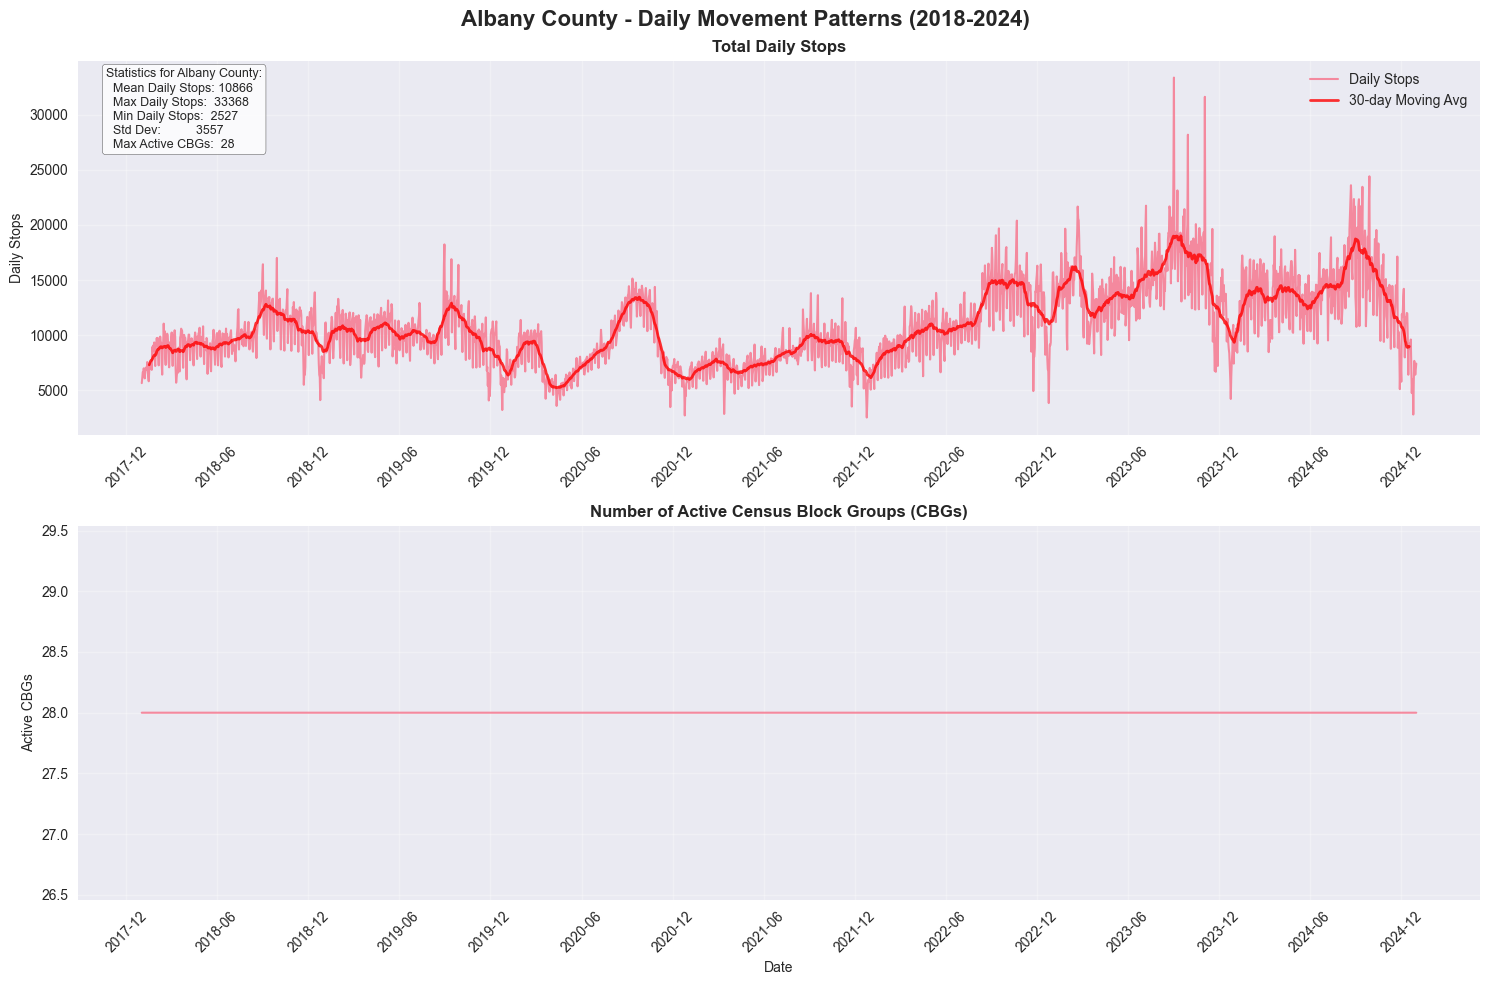

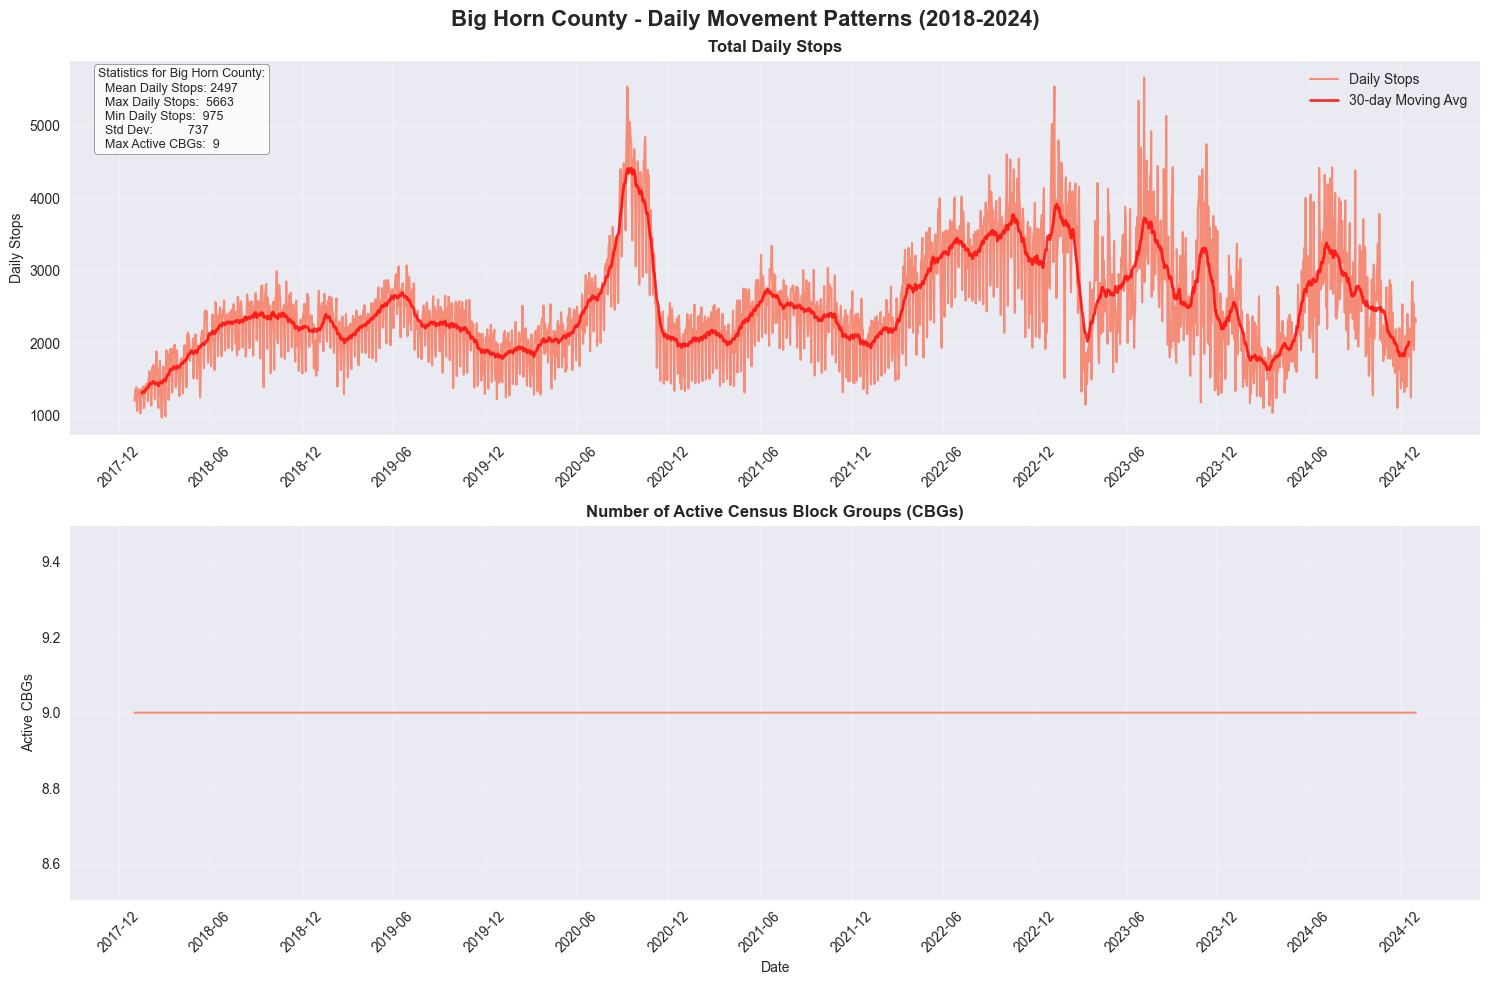

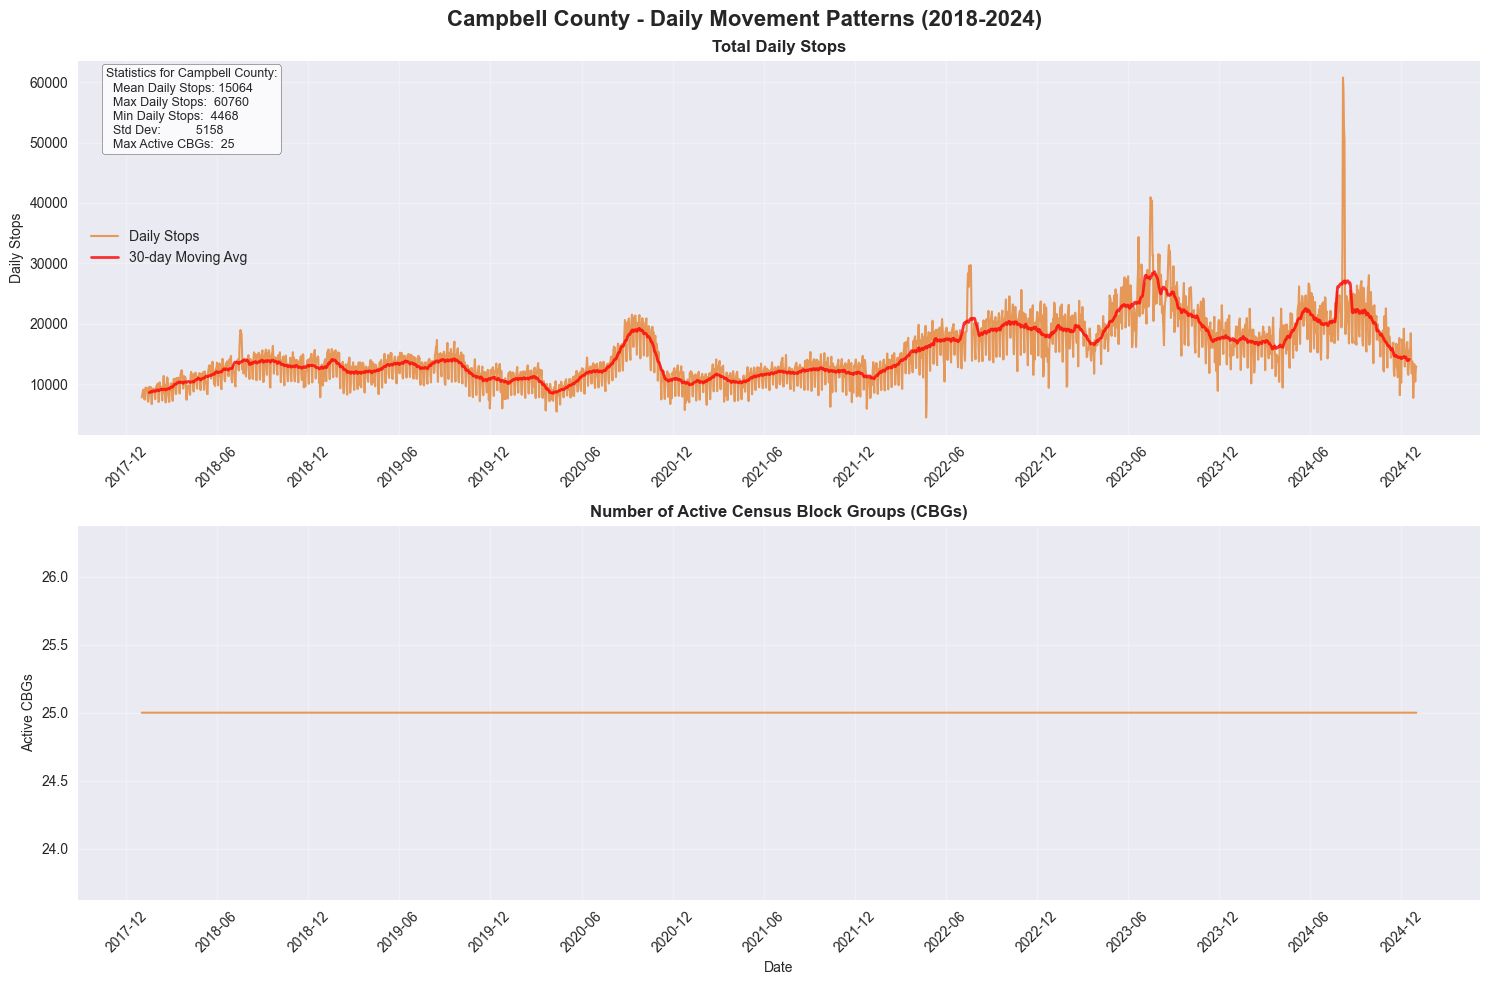

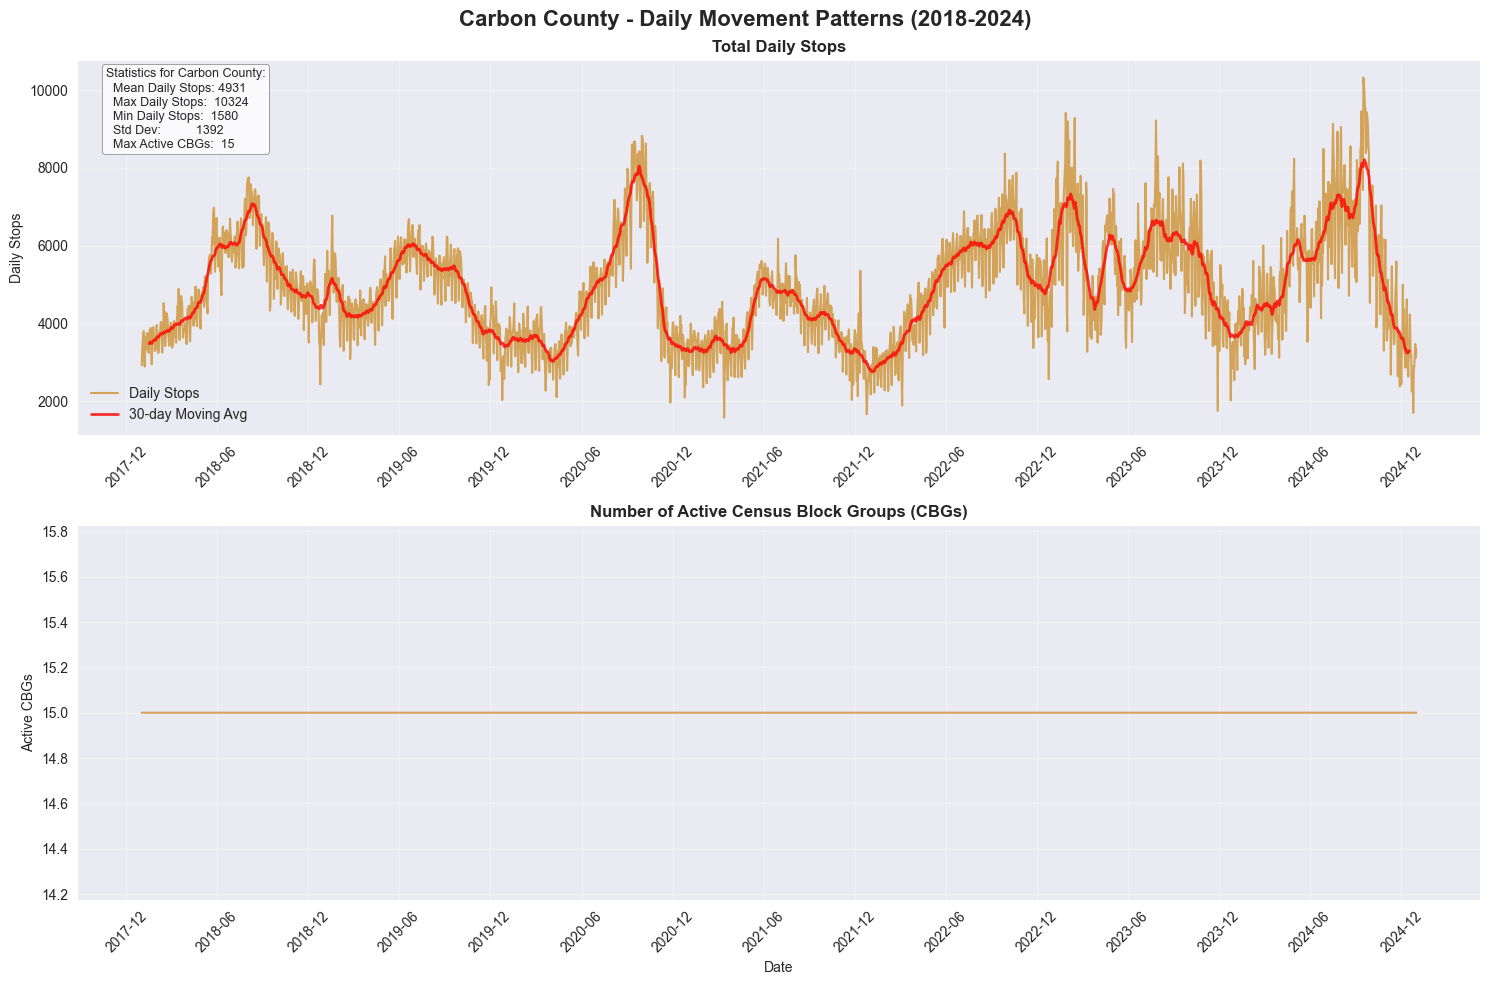

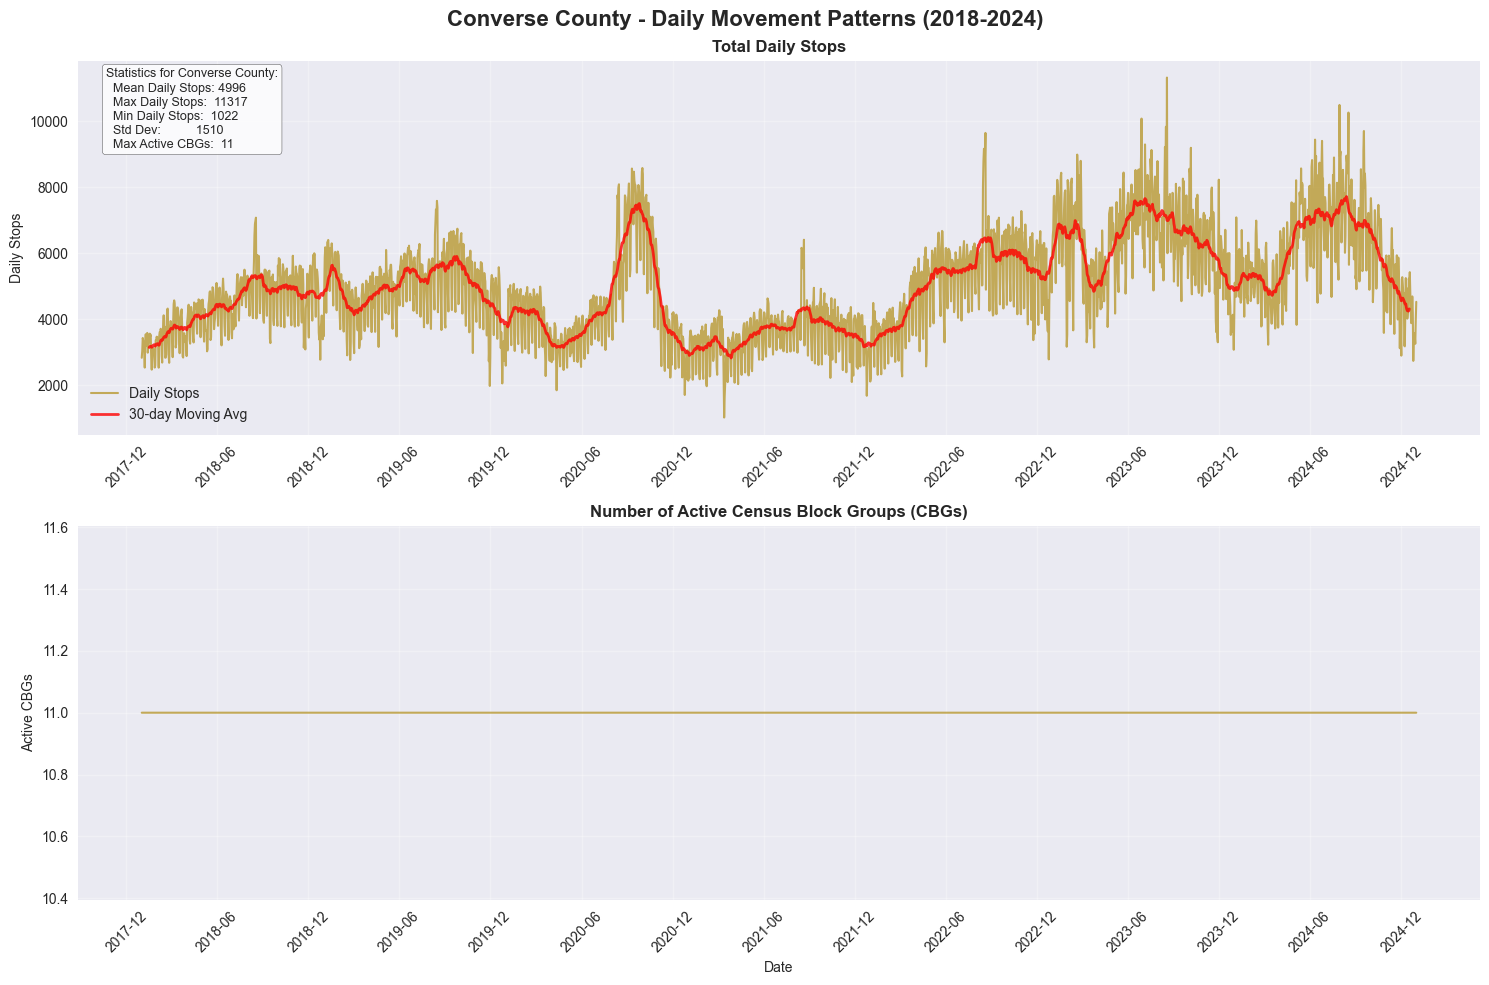

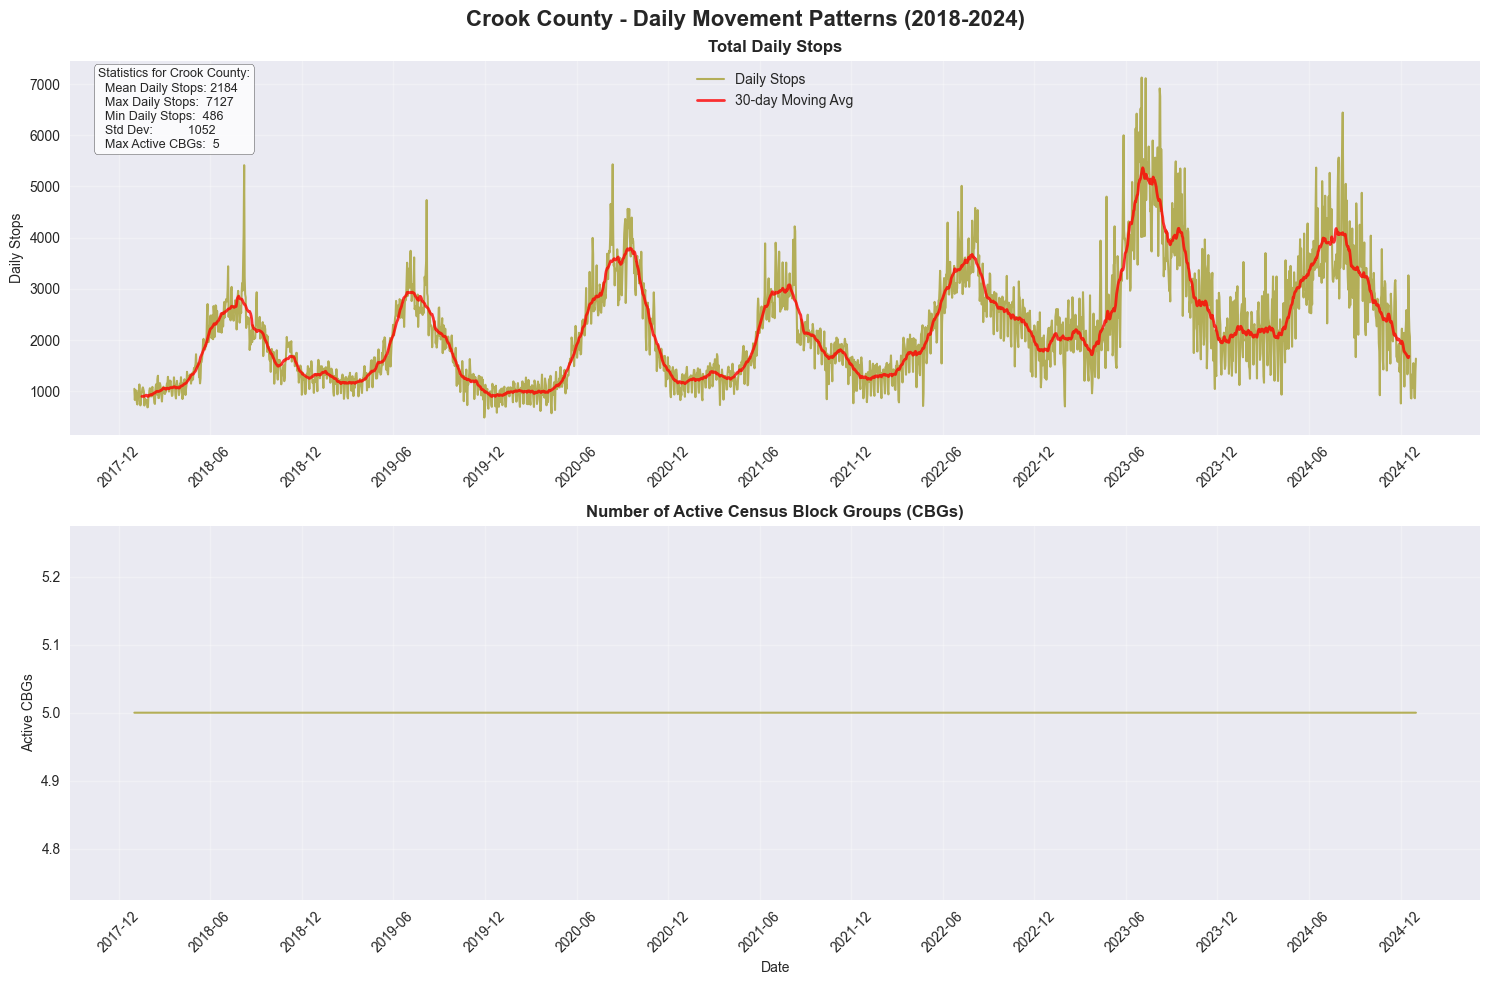

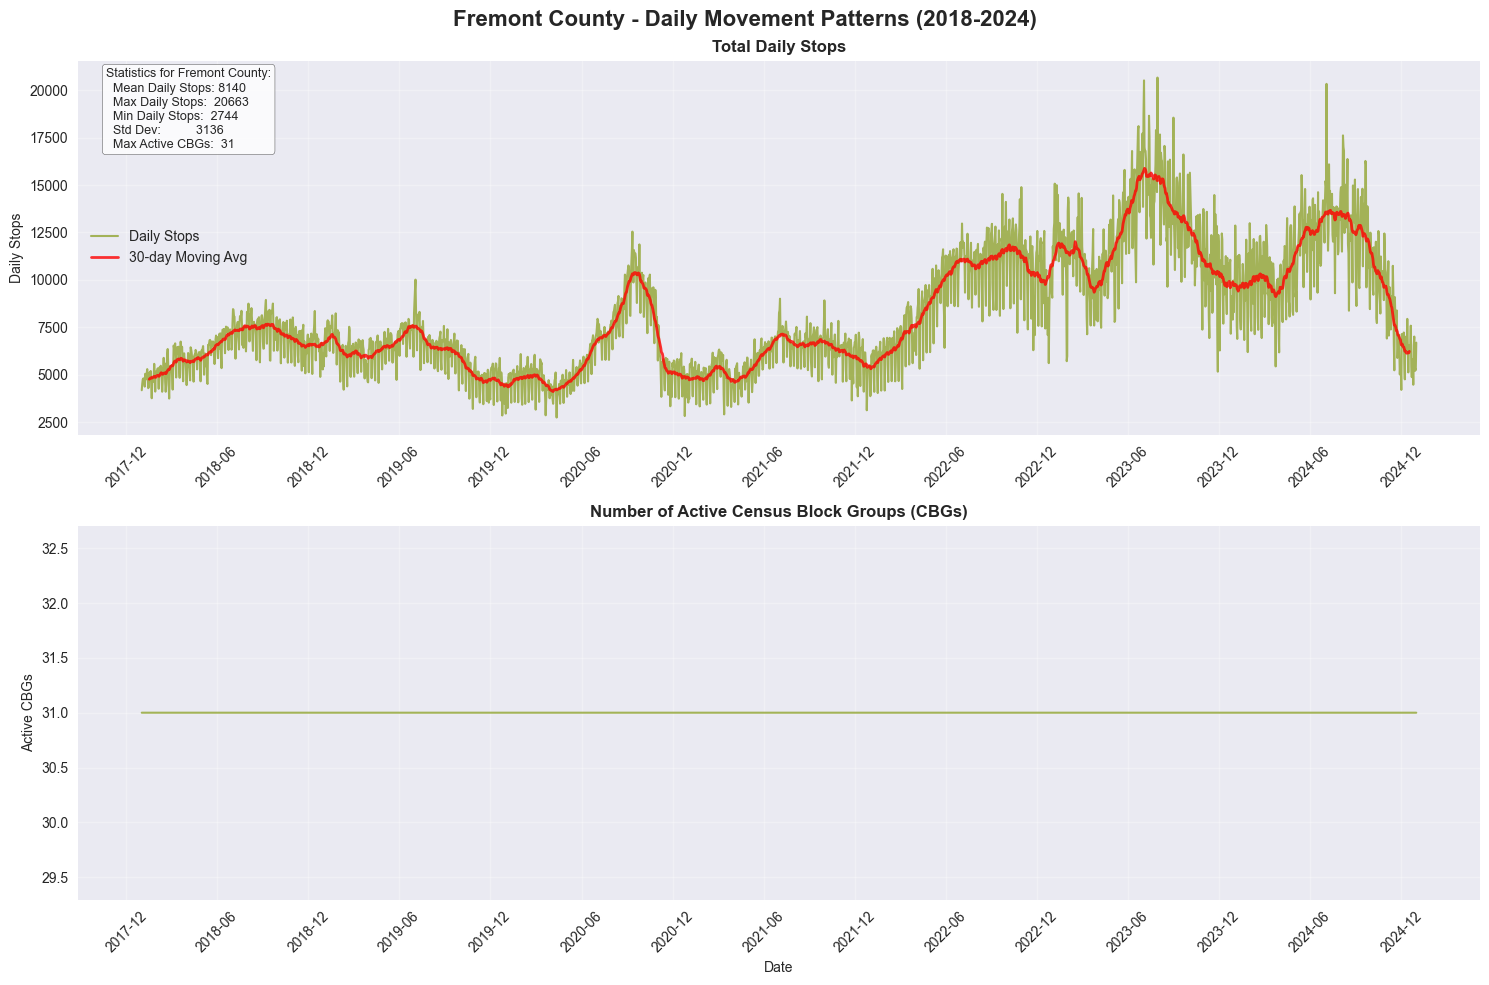

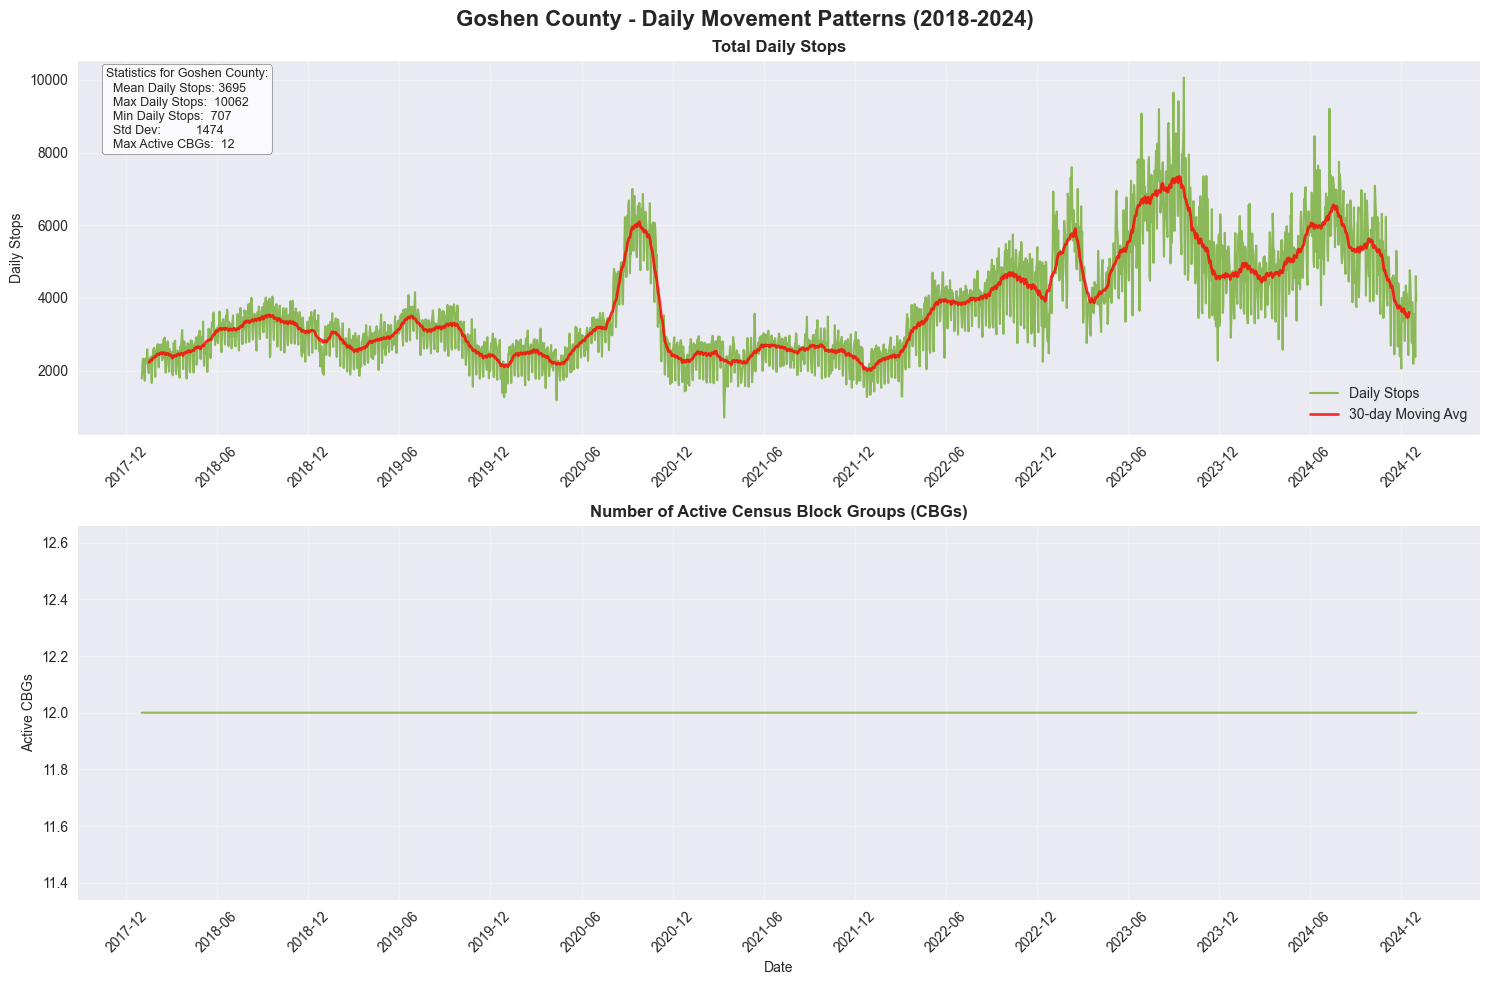

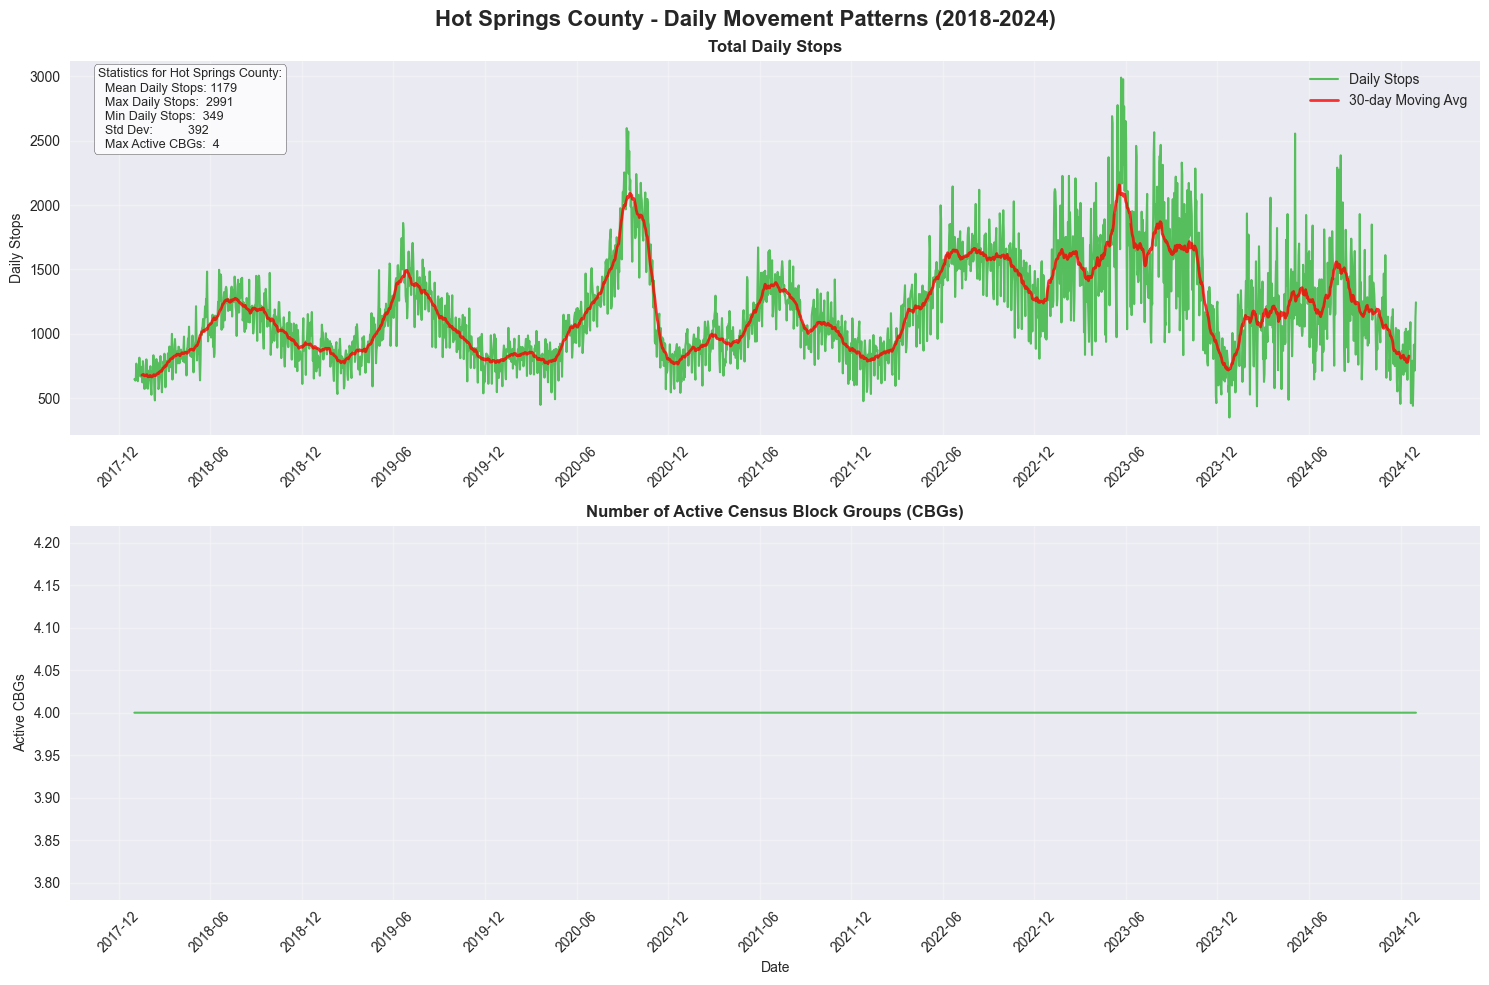

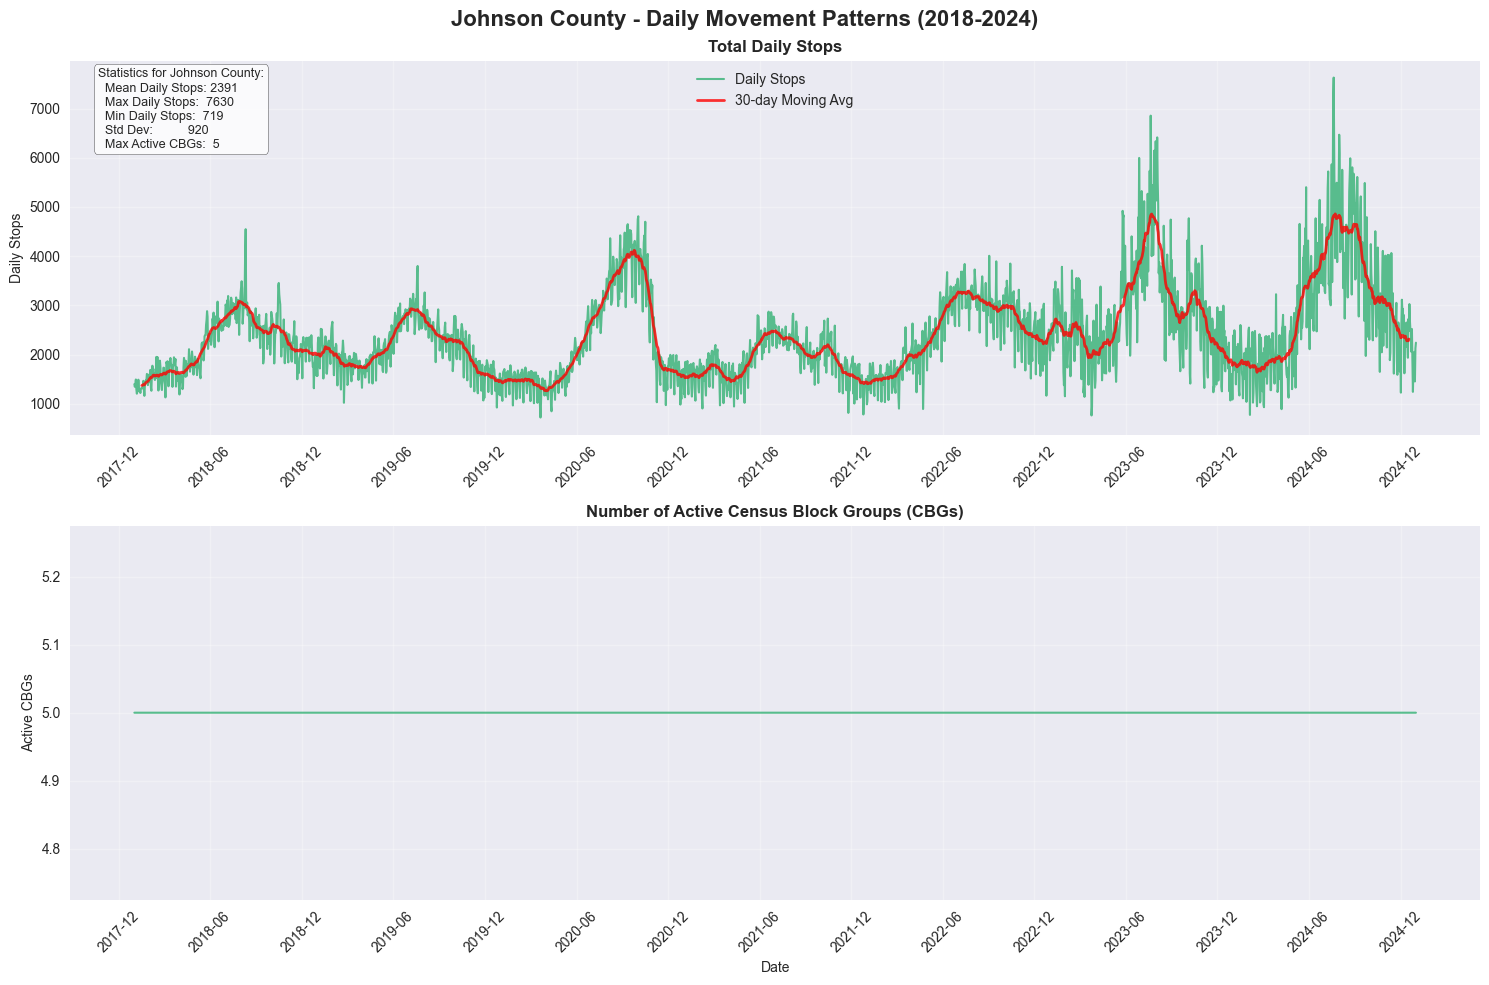

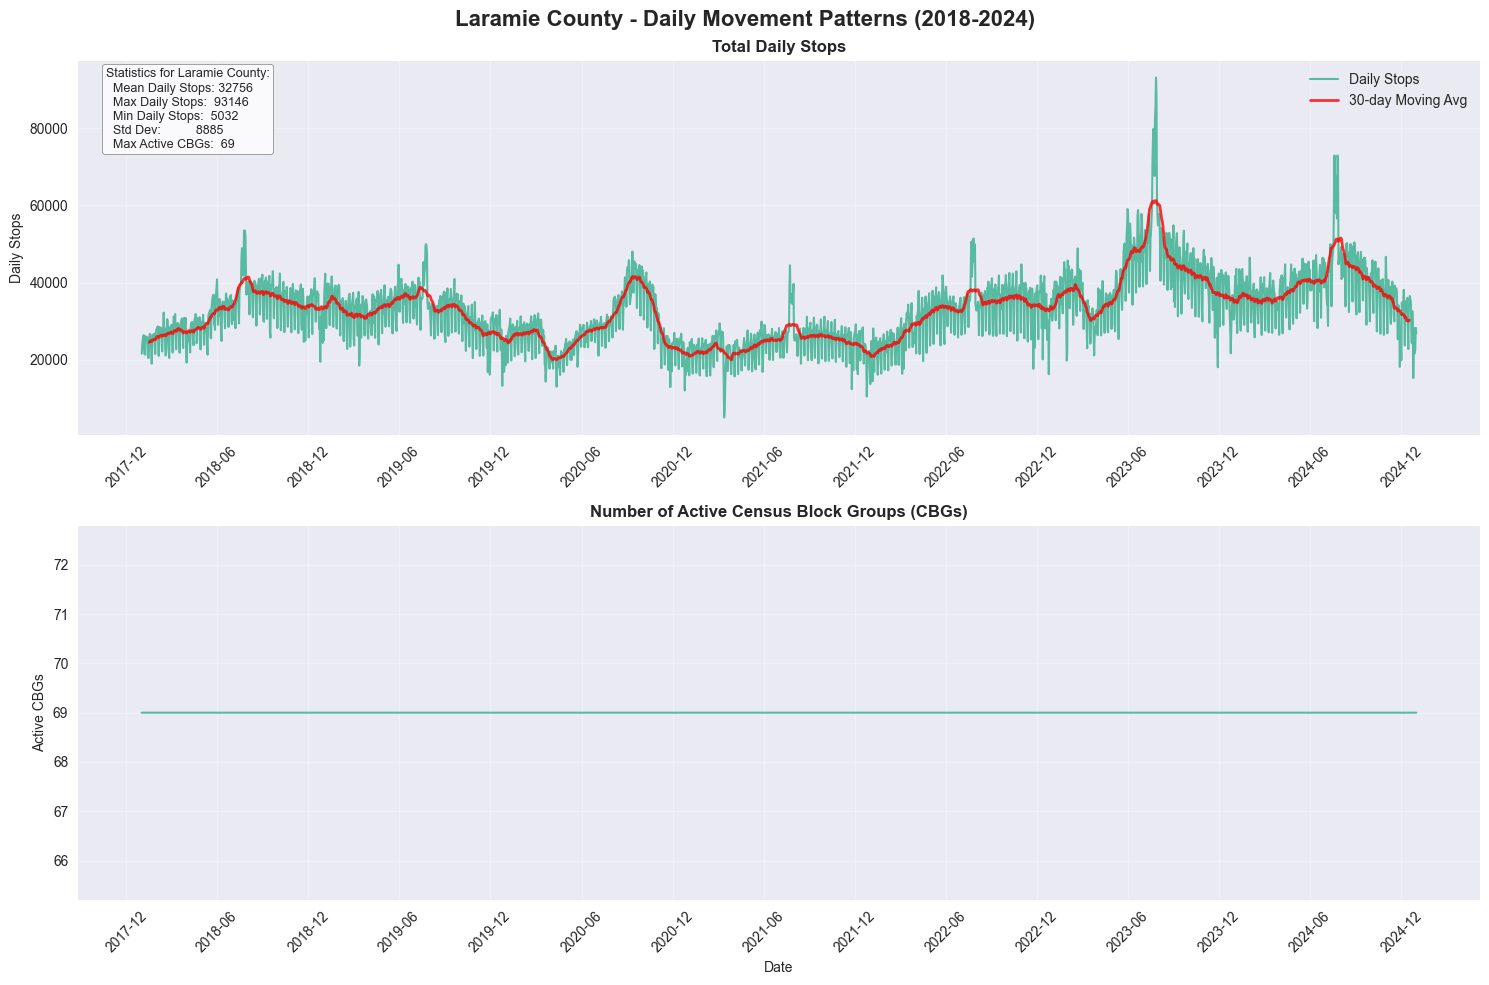

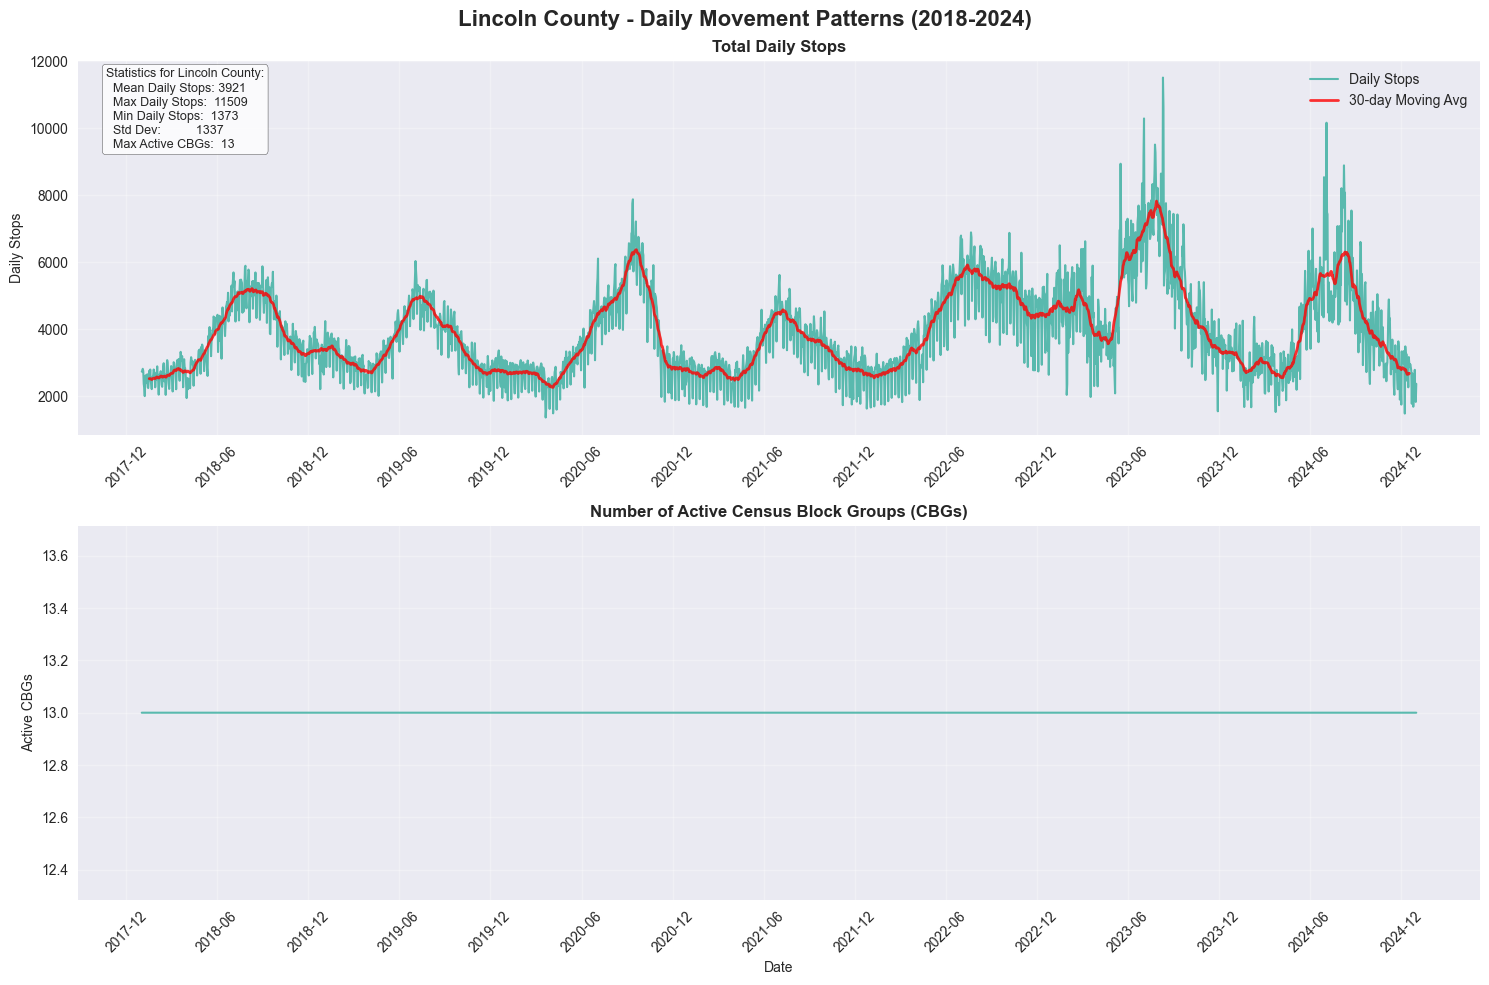

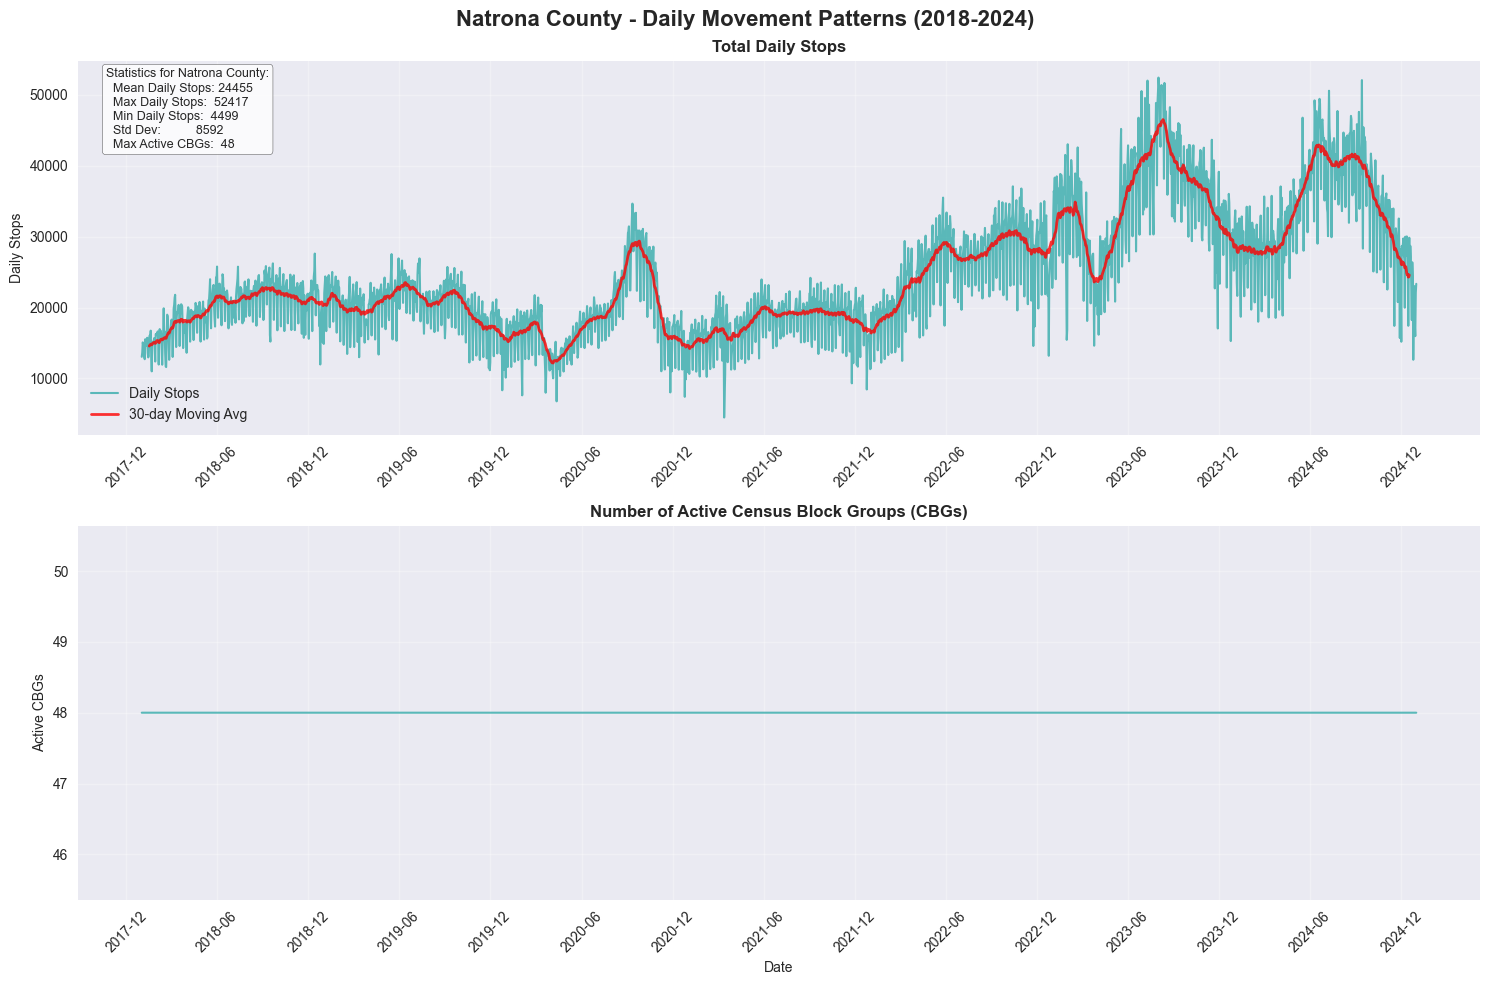

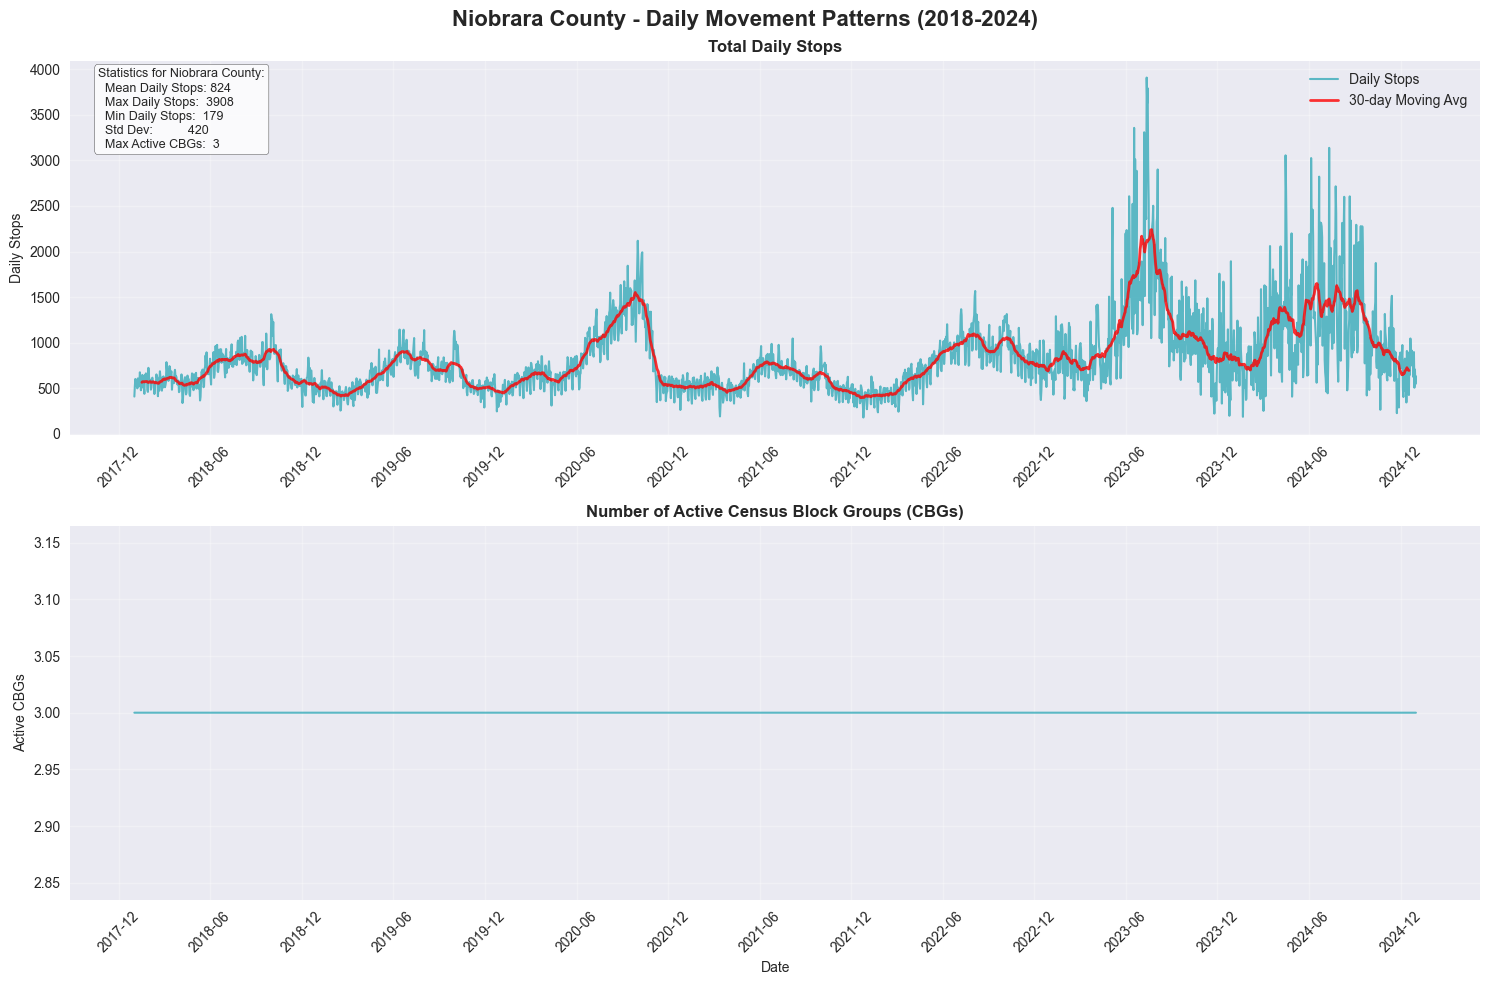

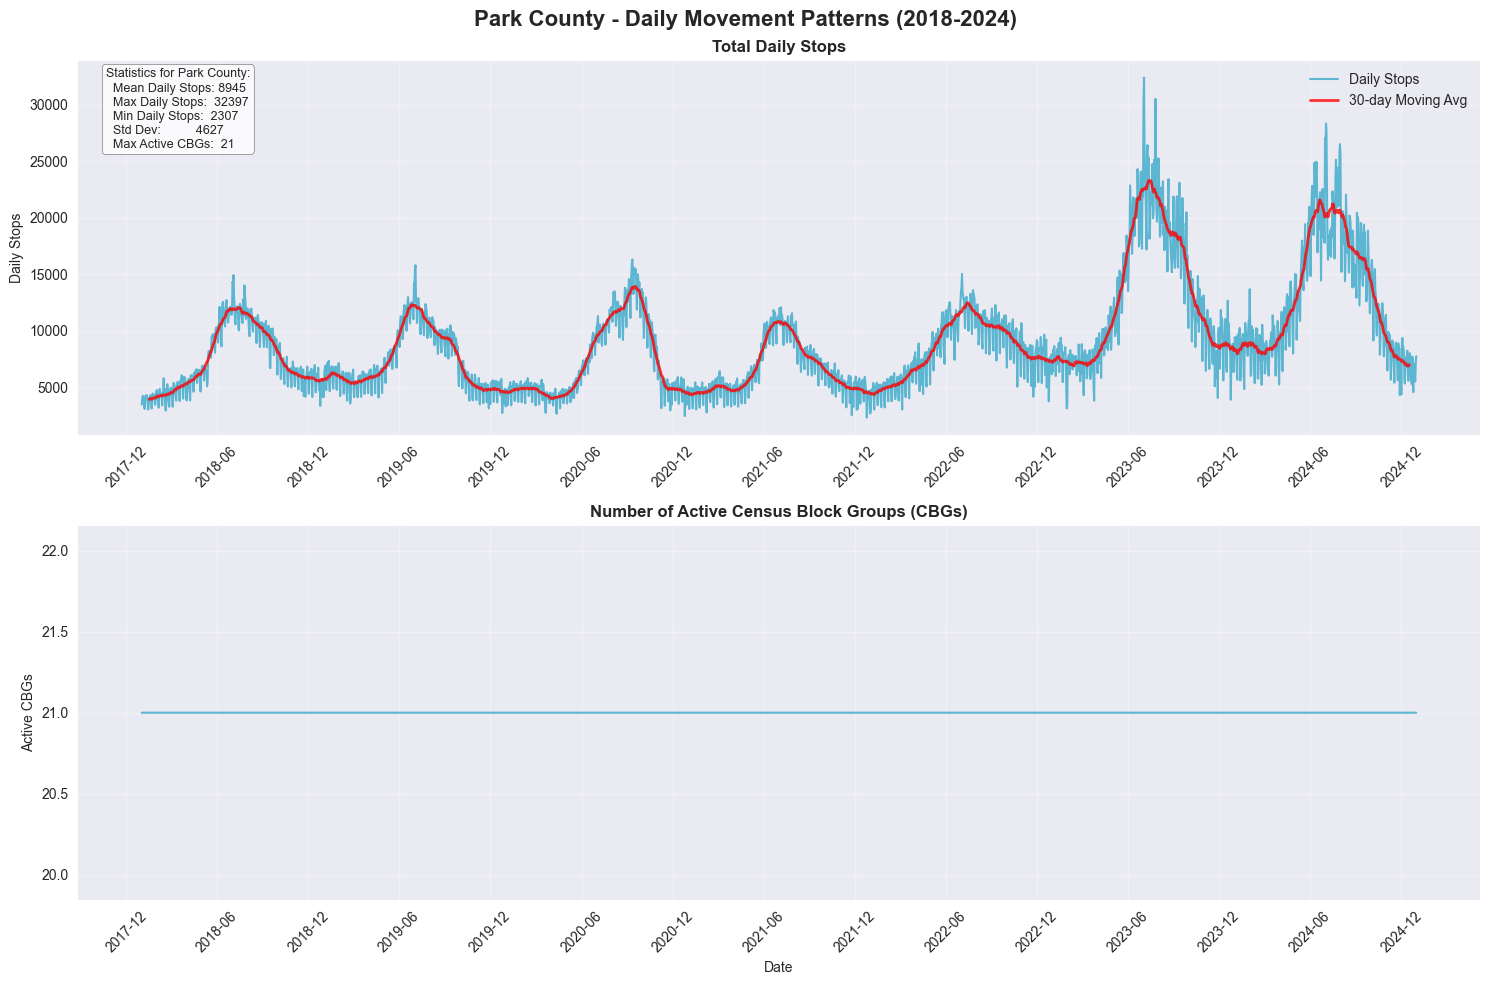

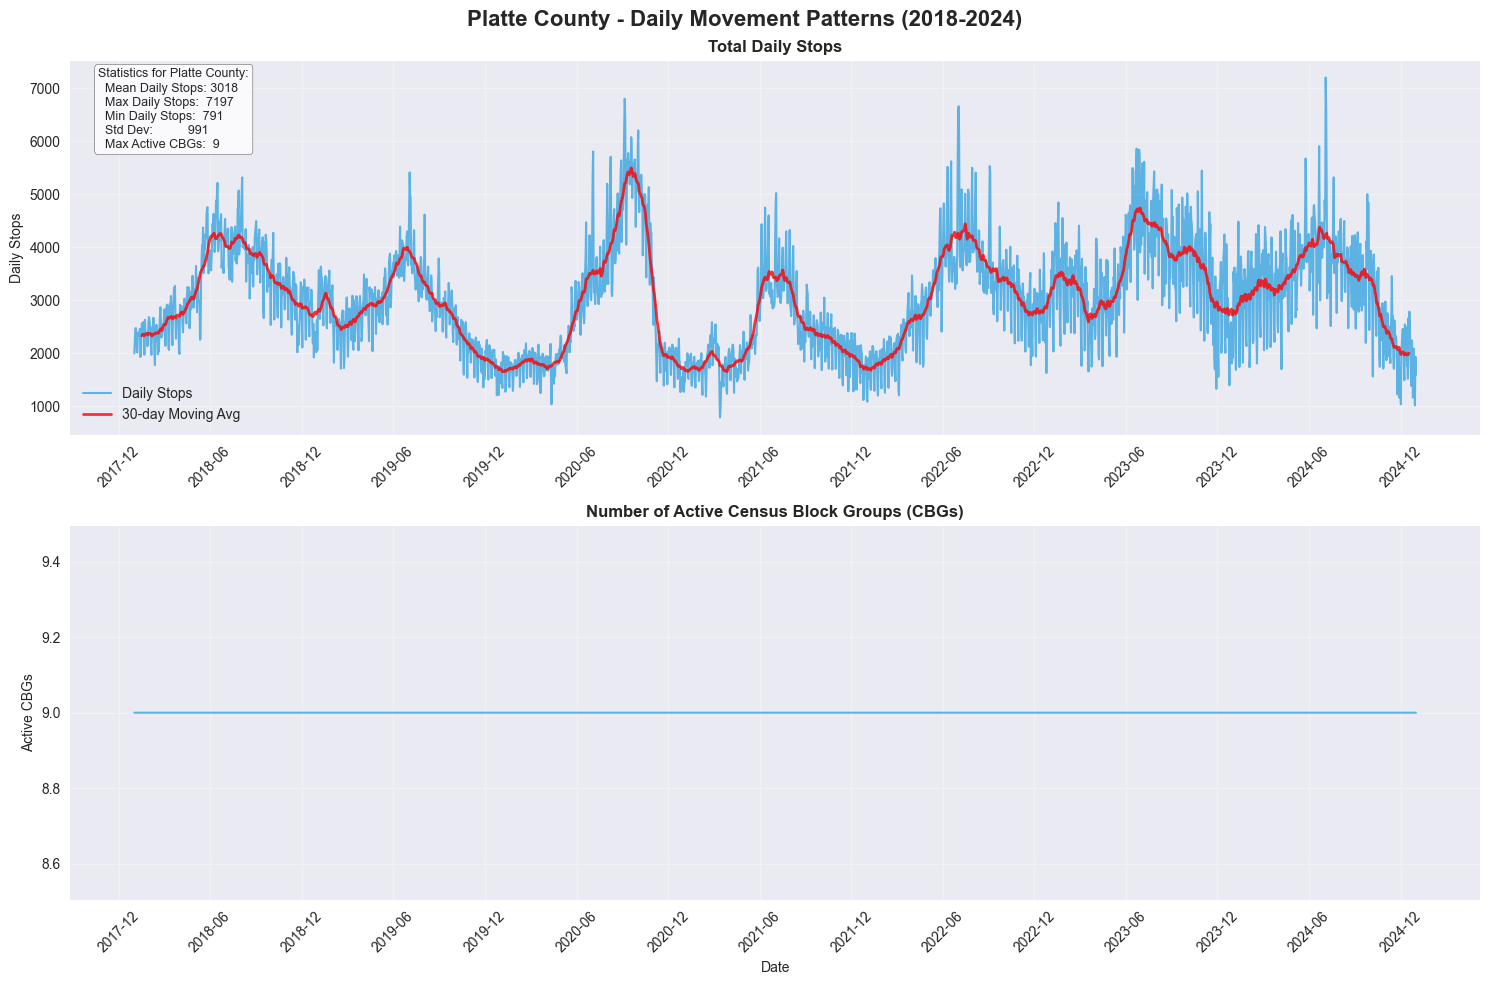

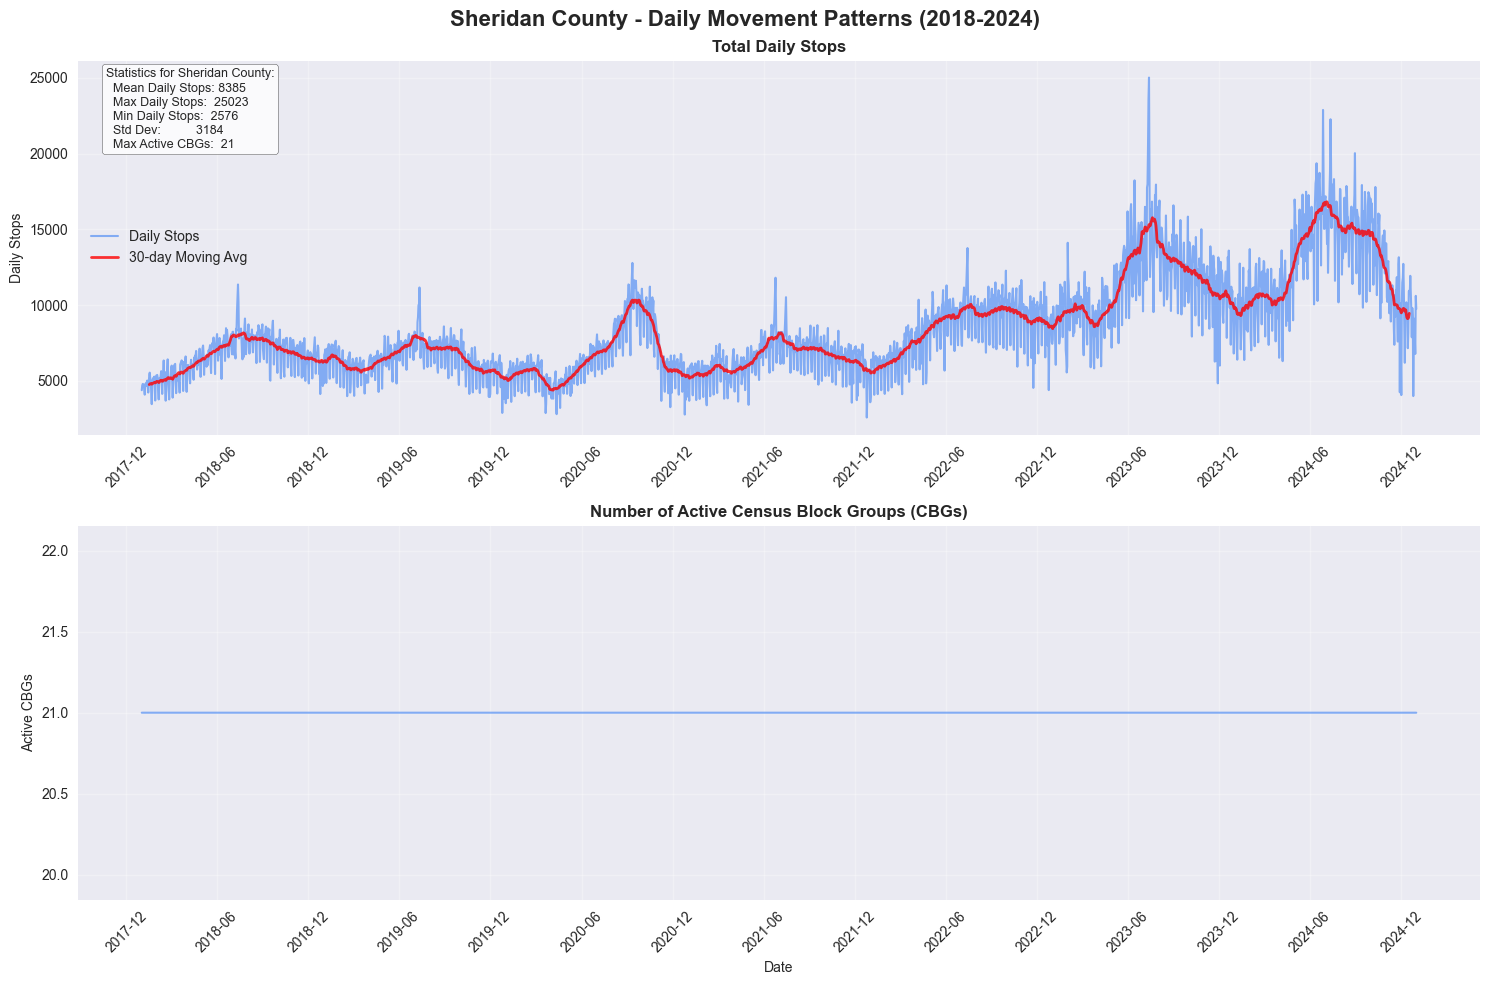

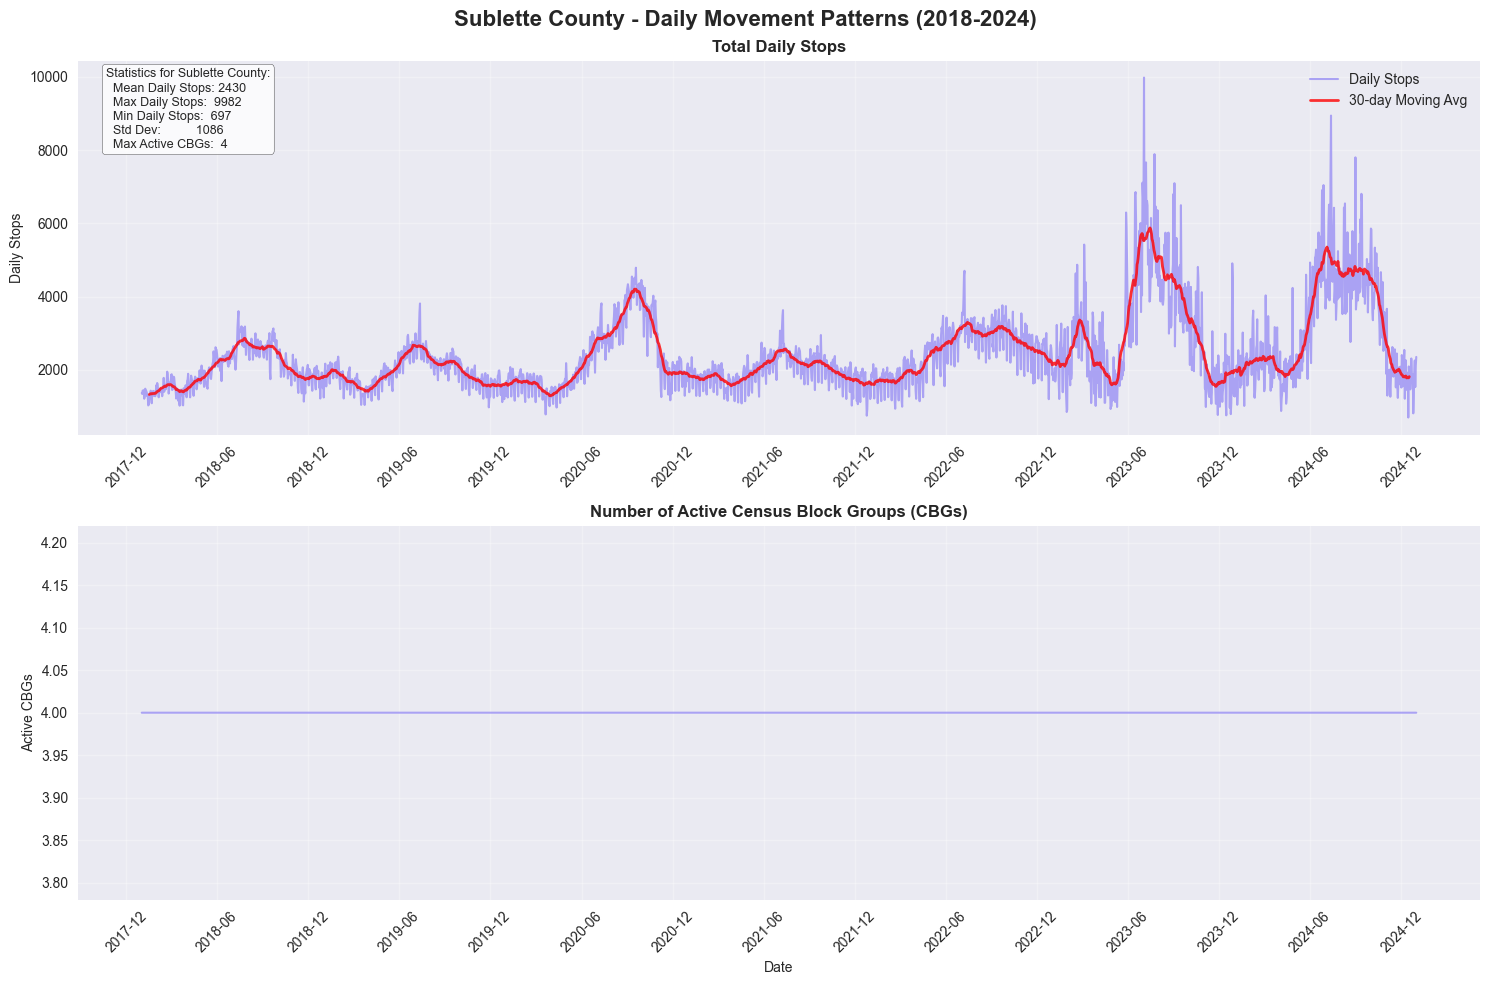

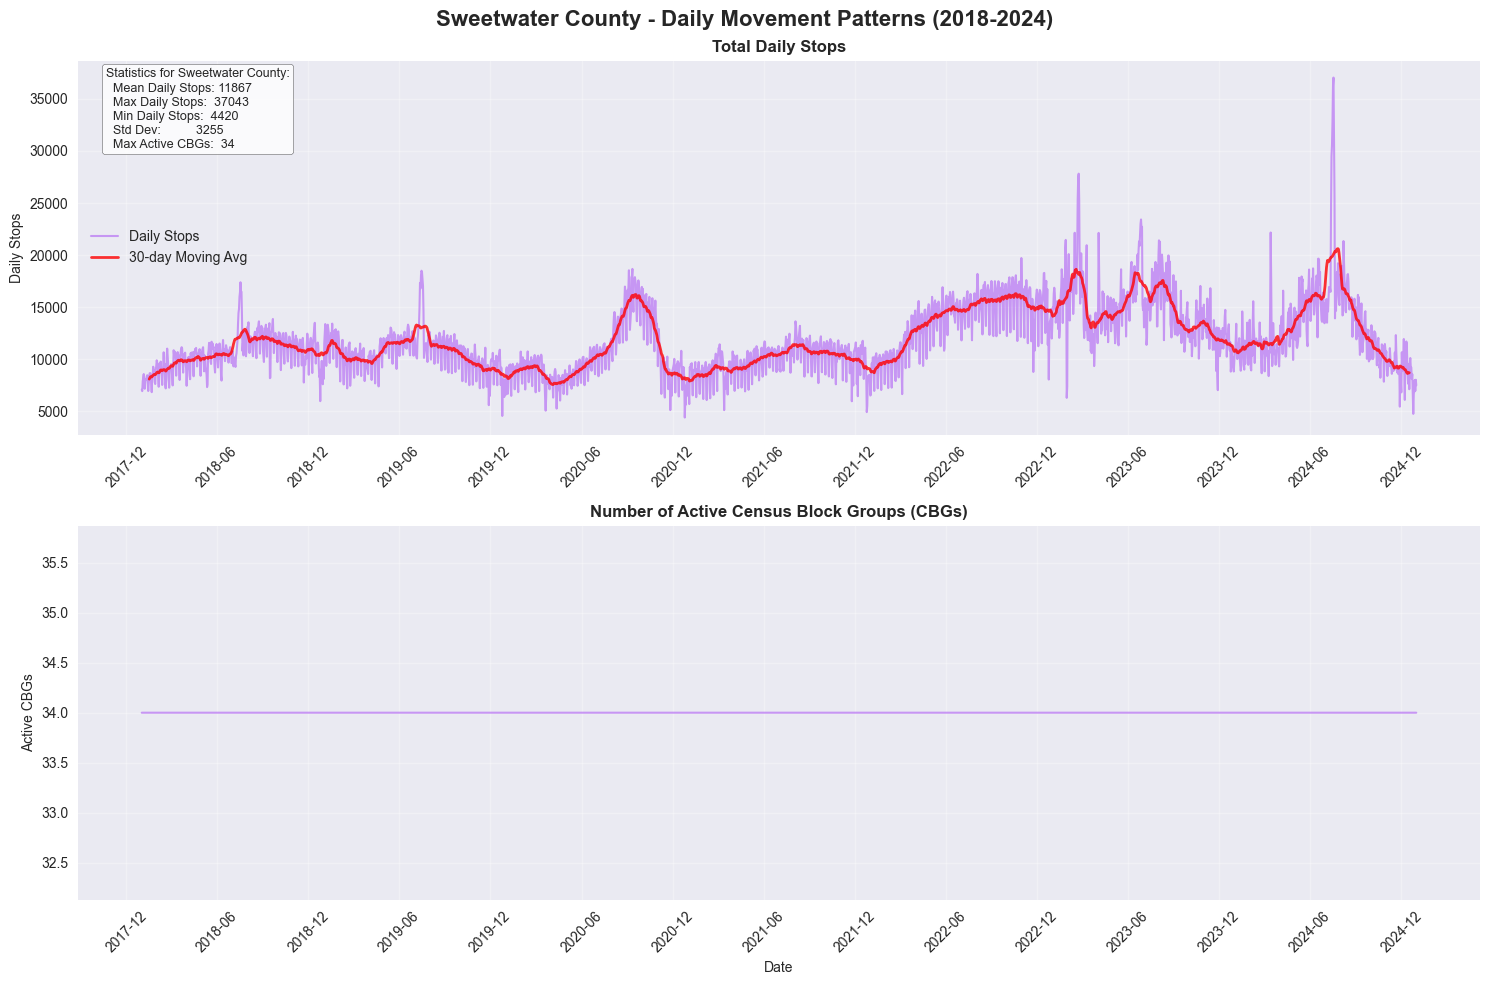

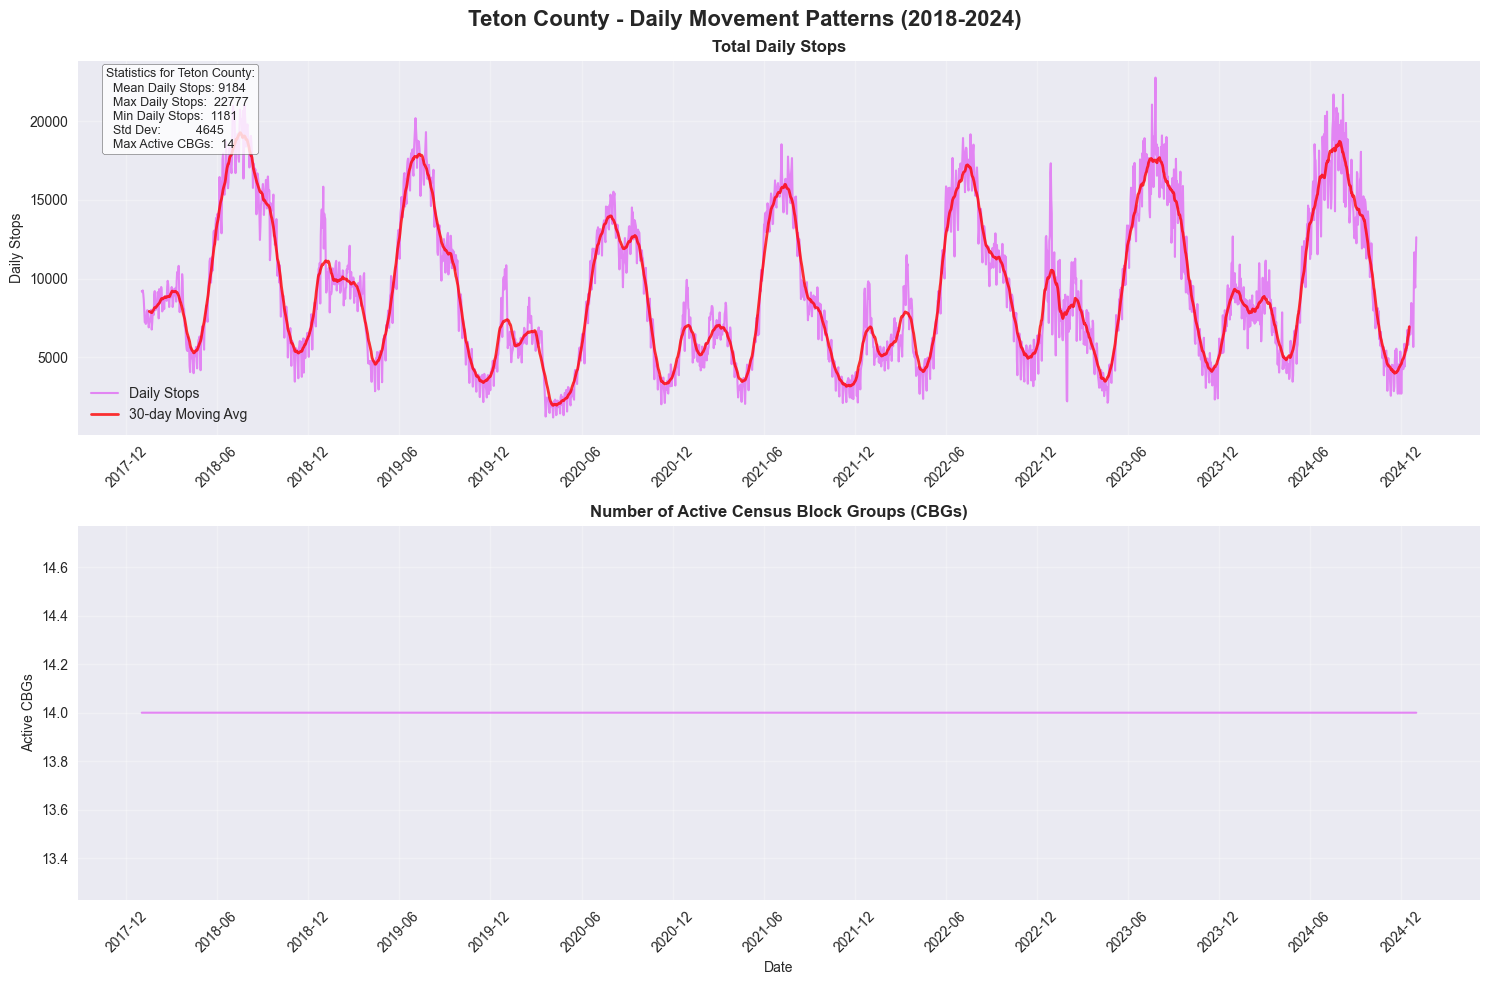

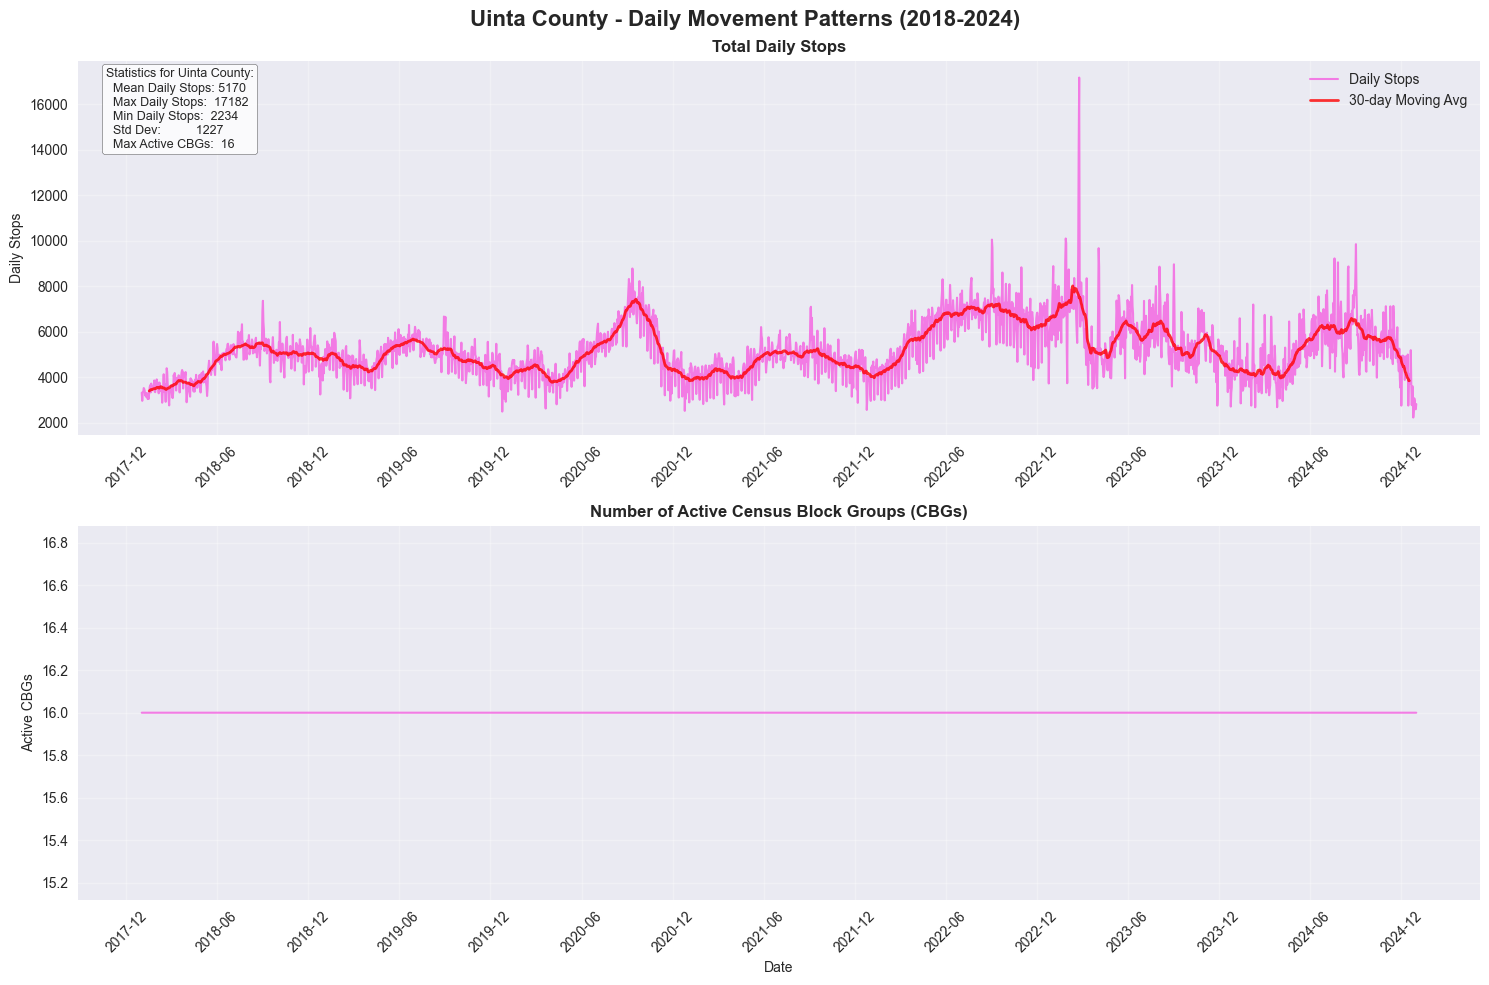

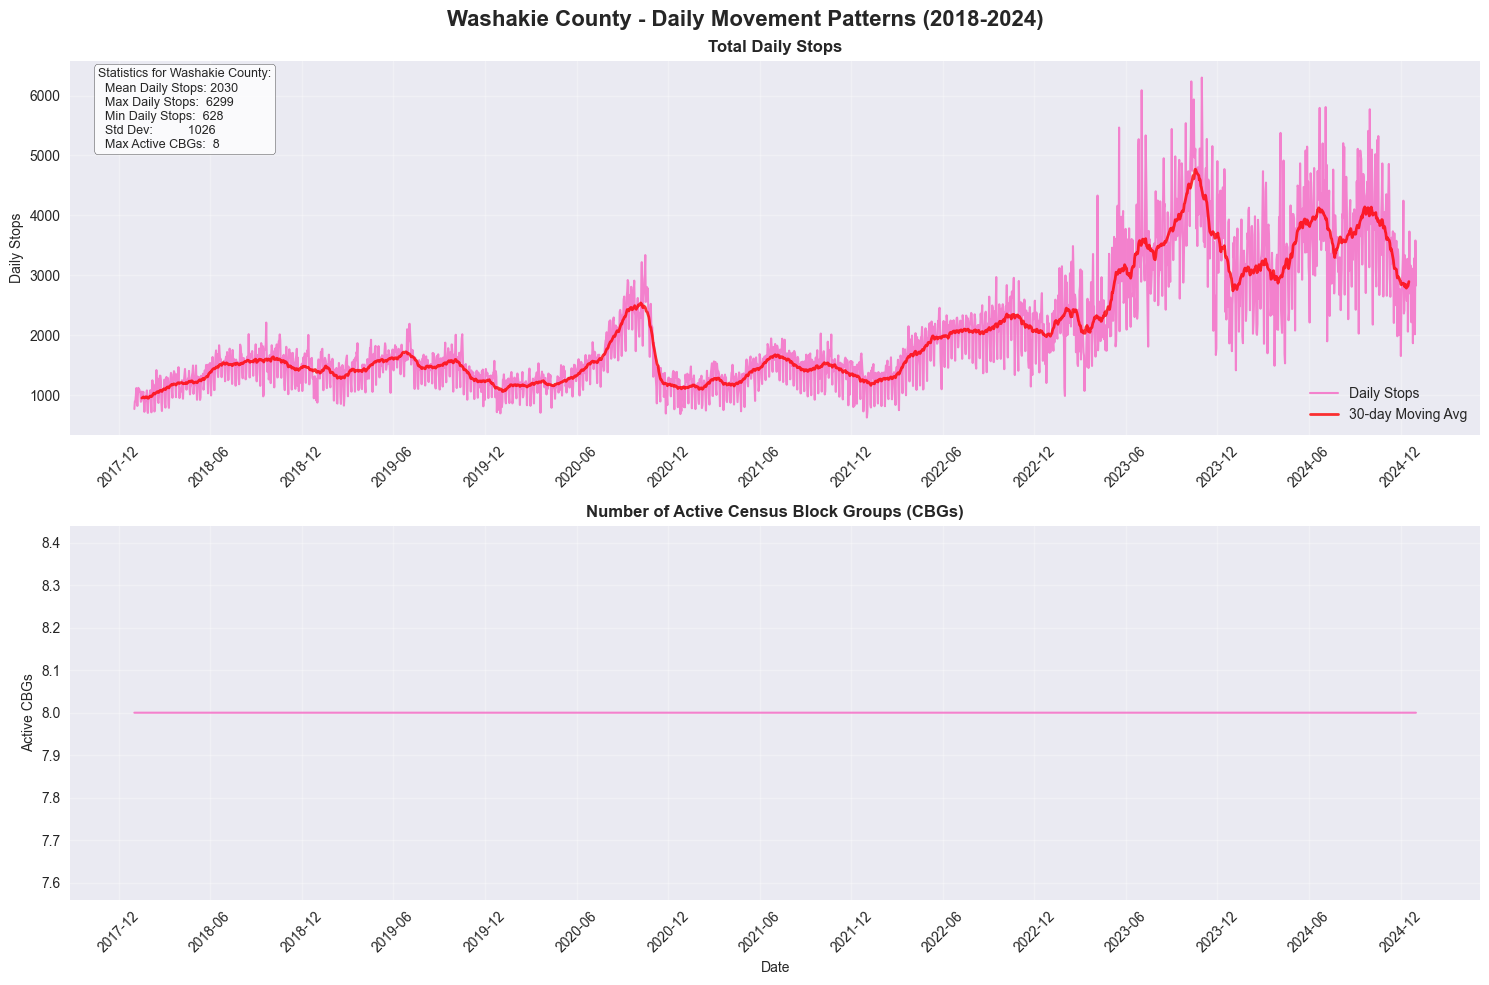

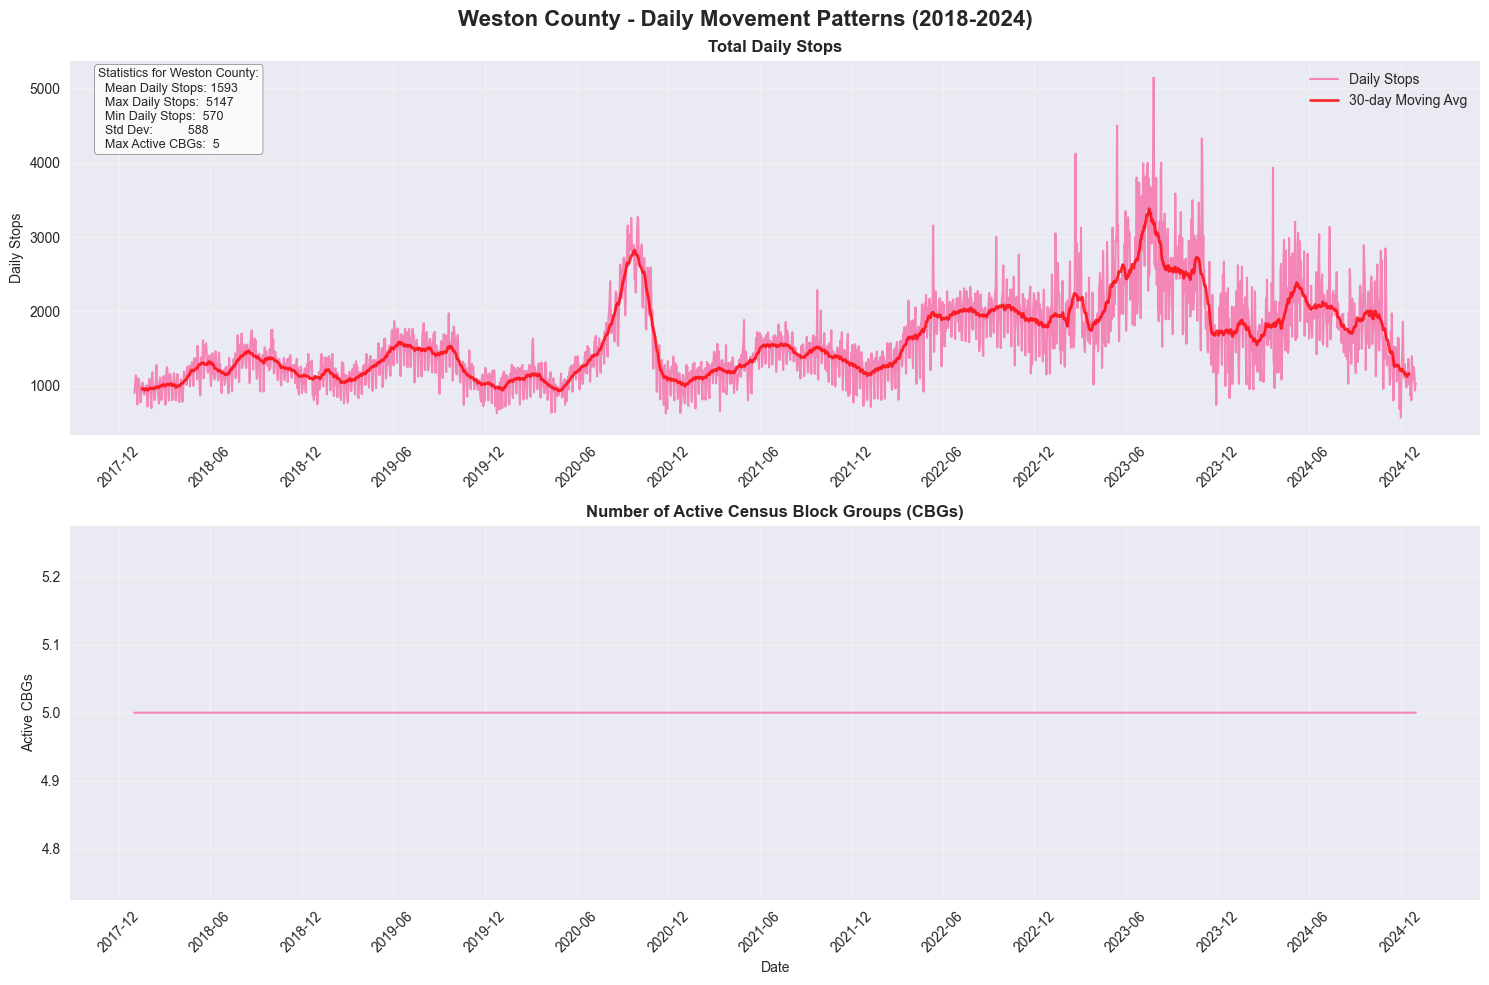

✓ Individual county plots saved in F:\Yellow Stone Flood-2022\floodanalysis\Plots\County_Timeseries\Individual_Counties


In [4]:
# Per-county time series:
# For each county, we make a 2-panel figure:
#   Top panel: total daily stops (raw + 30-day moving average)
#   Bottom panel: number of active CBGs that day
# We will also add a small stats box with values like mean and max in the top panel.



from pathlib import Path
import matplotlib.dates as mdates

def create_individual_county_plots(dataframe, out_dir, county_list, color_map):
    out_dir = Path(out_dir) / "Individual_Counties"
    out_dir.mkdir(exist_ok=True)

    for county in county_list:
        county_data = dataframe[dataframe['COUNTY_NAME'] == county].copy()

        # Rolling mean for smoothing high-frequency wiggle
        county_data['rolling_mean'] = (
            county_data['TOTAL_DAILY_STOPS']
            .rolling(window=30, center=True)
            .mean()
        )

        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        fig.suptitle(
            f"{county} - Daily Movement Patterns ({county_data['DATE'].min().year}-{county_data['DATE'].max().year})",
            fontsize=16,
            fontweight='bold'
        )

        # Panel 1: daily stops

        axes[0].plot(
            county_data['DATE'],
            county_data['TOTAL_DAILY_STOPS'],
            color=color_map[county],
            linewidth=1.5,
            alpha=0.8,
            label='Daily Stops'
        )

        axes[0].plot(
            county_data['DATE'],
            county_data['rolling_mean'],
            color='red',
            linewidth=2,
            alpha=0.8,
            label='30-day Moving Avg'
        )

        axes[0].set_title('Total Daily Stops', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Daily Stops', fontsize=10)
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()

        # stats box in upper-left
        stats_text = (
            f"Statistics for {county}:\n"
            f"  Mean Daily Stops: {county_data['TOTAL_DAILY_STOPS'].mean():.0f}\n"
            f"  Max Daily Stops:  {county_data['TOTAL_DAILY_STOPS'].max():.0f}\n"
            f"  Min Daily Stops:  {county_data['TOTAL_DAILY_STOPS'].min():.0f}\n"
            f"  Std Dev:          {county_data['TOTAL_DAILY_STOPS'].std():.0f}\n"
            f"  Max Active CBGs:  {county_data['UNIQUE_CBGS_COUNT'].max():.0f}"
        )

        axes[0].text(
            0.02, 0.98,
            stats_text,
            transform=axes[0].transAxes,
            va='top',
            bbox=dict(
                boxstyle='round',
                facecolor='white',
                alpha=0.8
            ),
            fontsize=9
        )

        # Panel 2: active CBG count
        axes[1].plot(
            county_data['DATE'],
            county_data['UNIQUE_CBGS_COUNT'],
            color=color_map[county],
            linewidth=1.5,
            alpha=0.8
        )

        axes[1].set_title('Number of Active Census Block Groups (CBGs)', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Active CBGs', fontsize=10)
        axes[1].set_xlabel('Date', fontsize=10)
        axes[1].grid(True, alpha=0.3)

        # Date formatting on x-axis 
        for ax in axes:
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()

        # Save per-county figure
        filename = f"{county.replace(' ', '_').replace('County', 'Co')}_timeseries.png"
        plt.savefig(out_dir / filename, dpi=300, bbox_inches='tight')

        # Show 
        plt.show()

        plt.close(fig)

    print(f"✓ Individual county plots saved in {out_dir}")
    

# run it
create_individual_county_plots(df, OUTPUT_DIR, counties, county_colors)


### ***4. Helper: All-county comparison Plots***

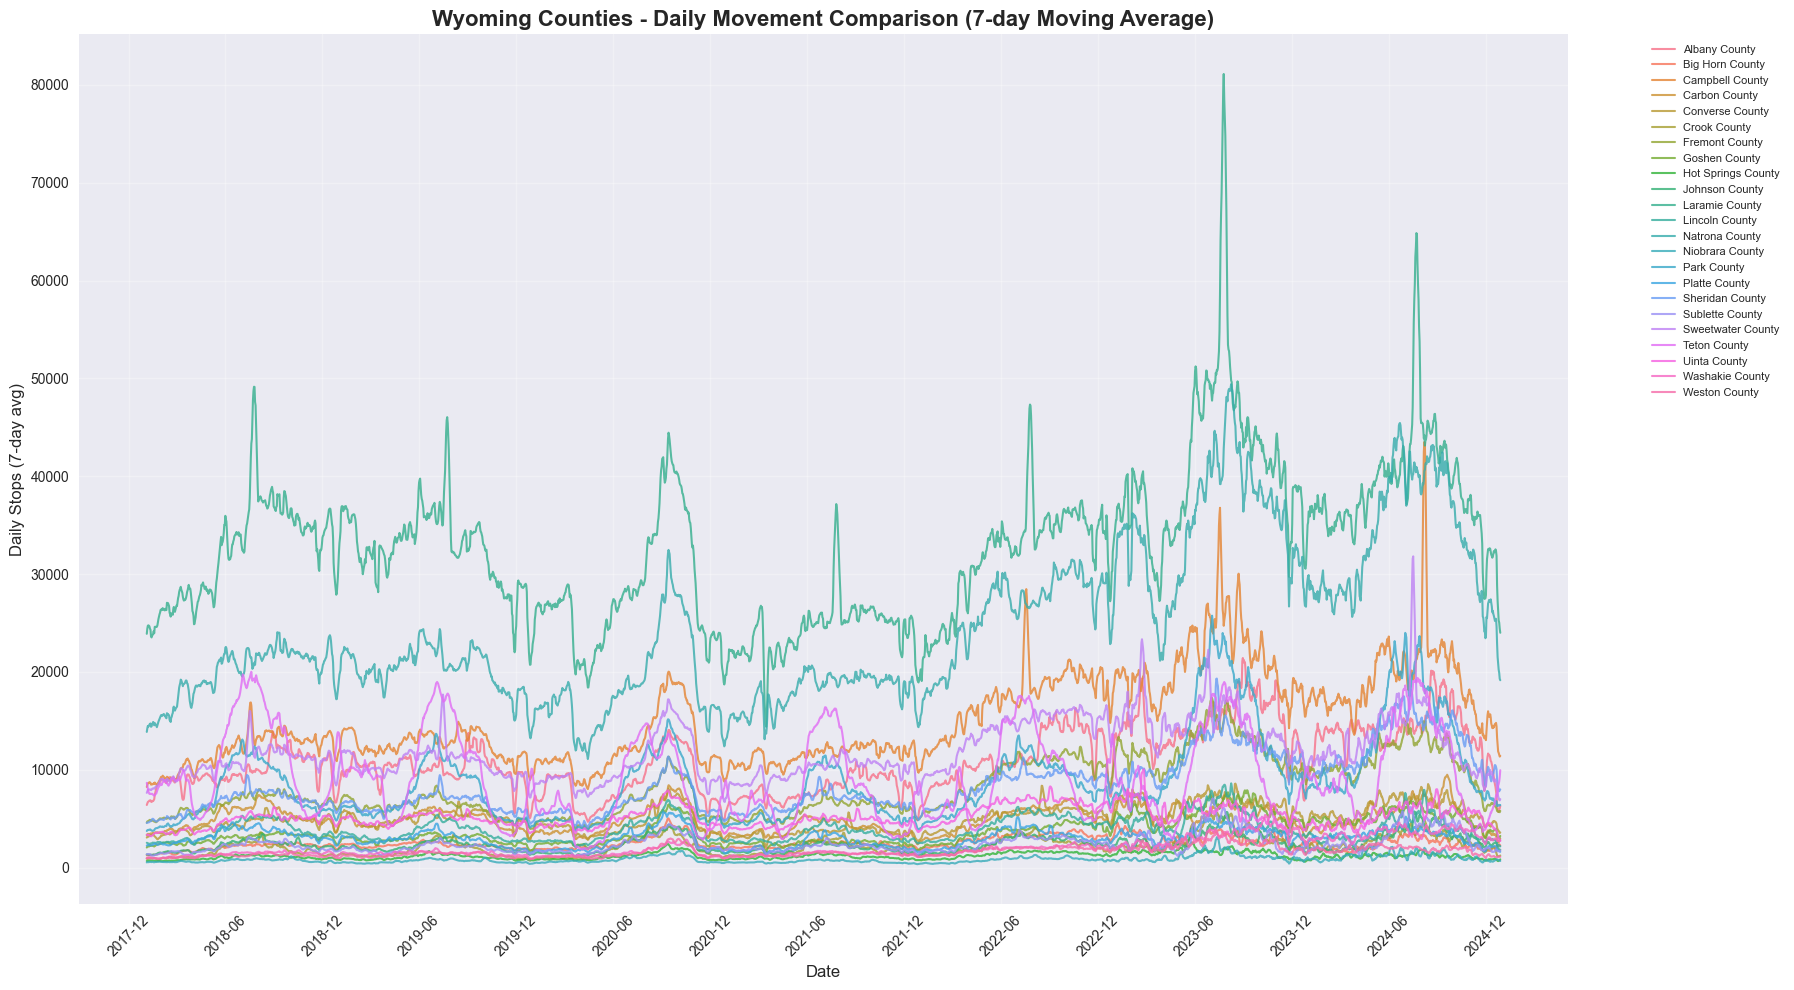

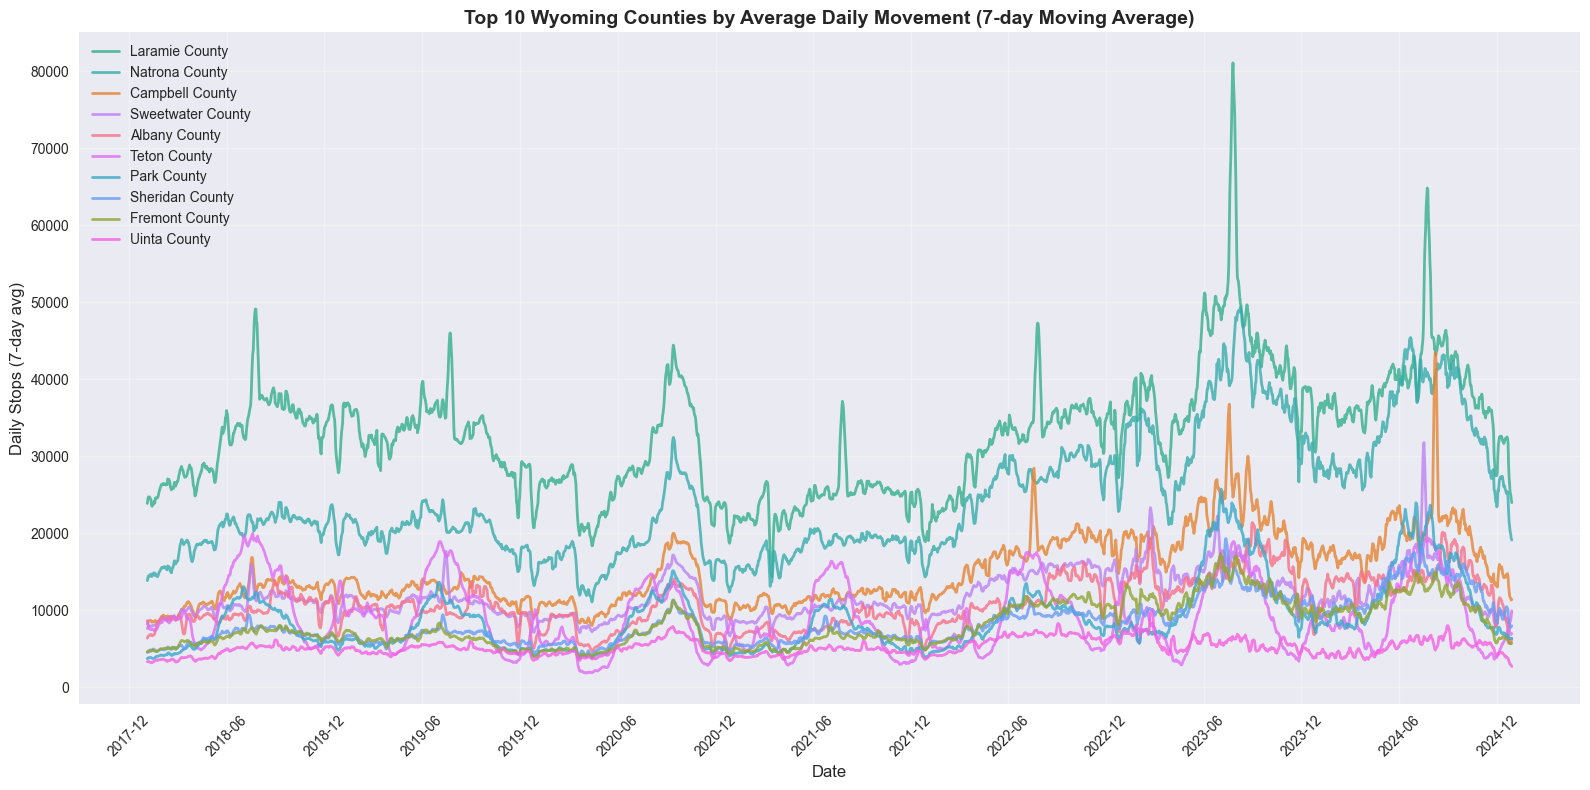

In [5]:
# Now let's compare counties directly on the same axes.
# Plot A: All counties, 7-day rolling average, same figure with legend on side
# Plot B: Top 10 movement counties by average daily stops overall
# Both plots are saved to disk and displayed here.


def create_comparative_plots(dataframe, out_dir, county_list, color_map):
    out_dir = Path(out_dir)

    # All counties (7-day smooth)

    fig, ax = plt.subplots(figsize=(18, 10))

    for county in county_list:
        county_data = dataframe[dataframe['COUNTY_NAME'] == county].copy()
        county_data['rolling_mean'] = (
            county_data['TOTAL_DAILY_STOPS']
            .rolling(window=7, center=True)
            .mean()
        )

        ax.plot(
            county_data['DATE'],
            county_data['rolling_mean'],
            color=color_map[county],
            linewidth=1.5,
            alpha=0.8,
            label=county
        )

    ax.set_title(
        'Wyoming Counties - Daily Movement Comparison (7-day Moving Average)',
        fontsize=16,
        fontweight='bold'
    )
    ax.set_ylabel('Daily Stops (7-day avg)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(out_dir / "All_Counties_Comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


    # Top 10 counties by mean daily stops

    county_avg = (
        dataframe
        .groupby('COUNTY_NAME')['TOTAL_DAILY_STOPS']
        .mean()
        .sort_values(ascending=False)
    )
    top_counties = county_avg.head(10).index.tolist()

    fig, ax = plt.subplots(figsize=(16, 8))

    for county in top_counties:
        county_data = dataframe[dataframe['COUNTY_NAME'] == county].copy()
        county_data['rolling_mean'] = (
            county_data['TOTAL_DAILY_STOPS']
            .rolling(window=7, center=True)
            .mean()
        )

        ax.plot(
            county_data['DATE'],
            county_data['rolling_mean'],
            color=color_map[county],
            linewidth=2,
            alpha=0.8,
            label=county
        )

    ax.set_title(
        'Top 10 Wyoming Counties by Average Daily Movement (7-day Moving Average)',
        fontsize=14,
        fontweight='bold'
    )
    ax.set_ylabel('Daily Stops (7-day avg)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(out_dir / "Top10_Counties_Comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


# run it
create_comparative_plots(df, OUTPUT_DIR, counties, county_colors)


### ***5. Heatmap view of Seasonality***

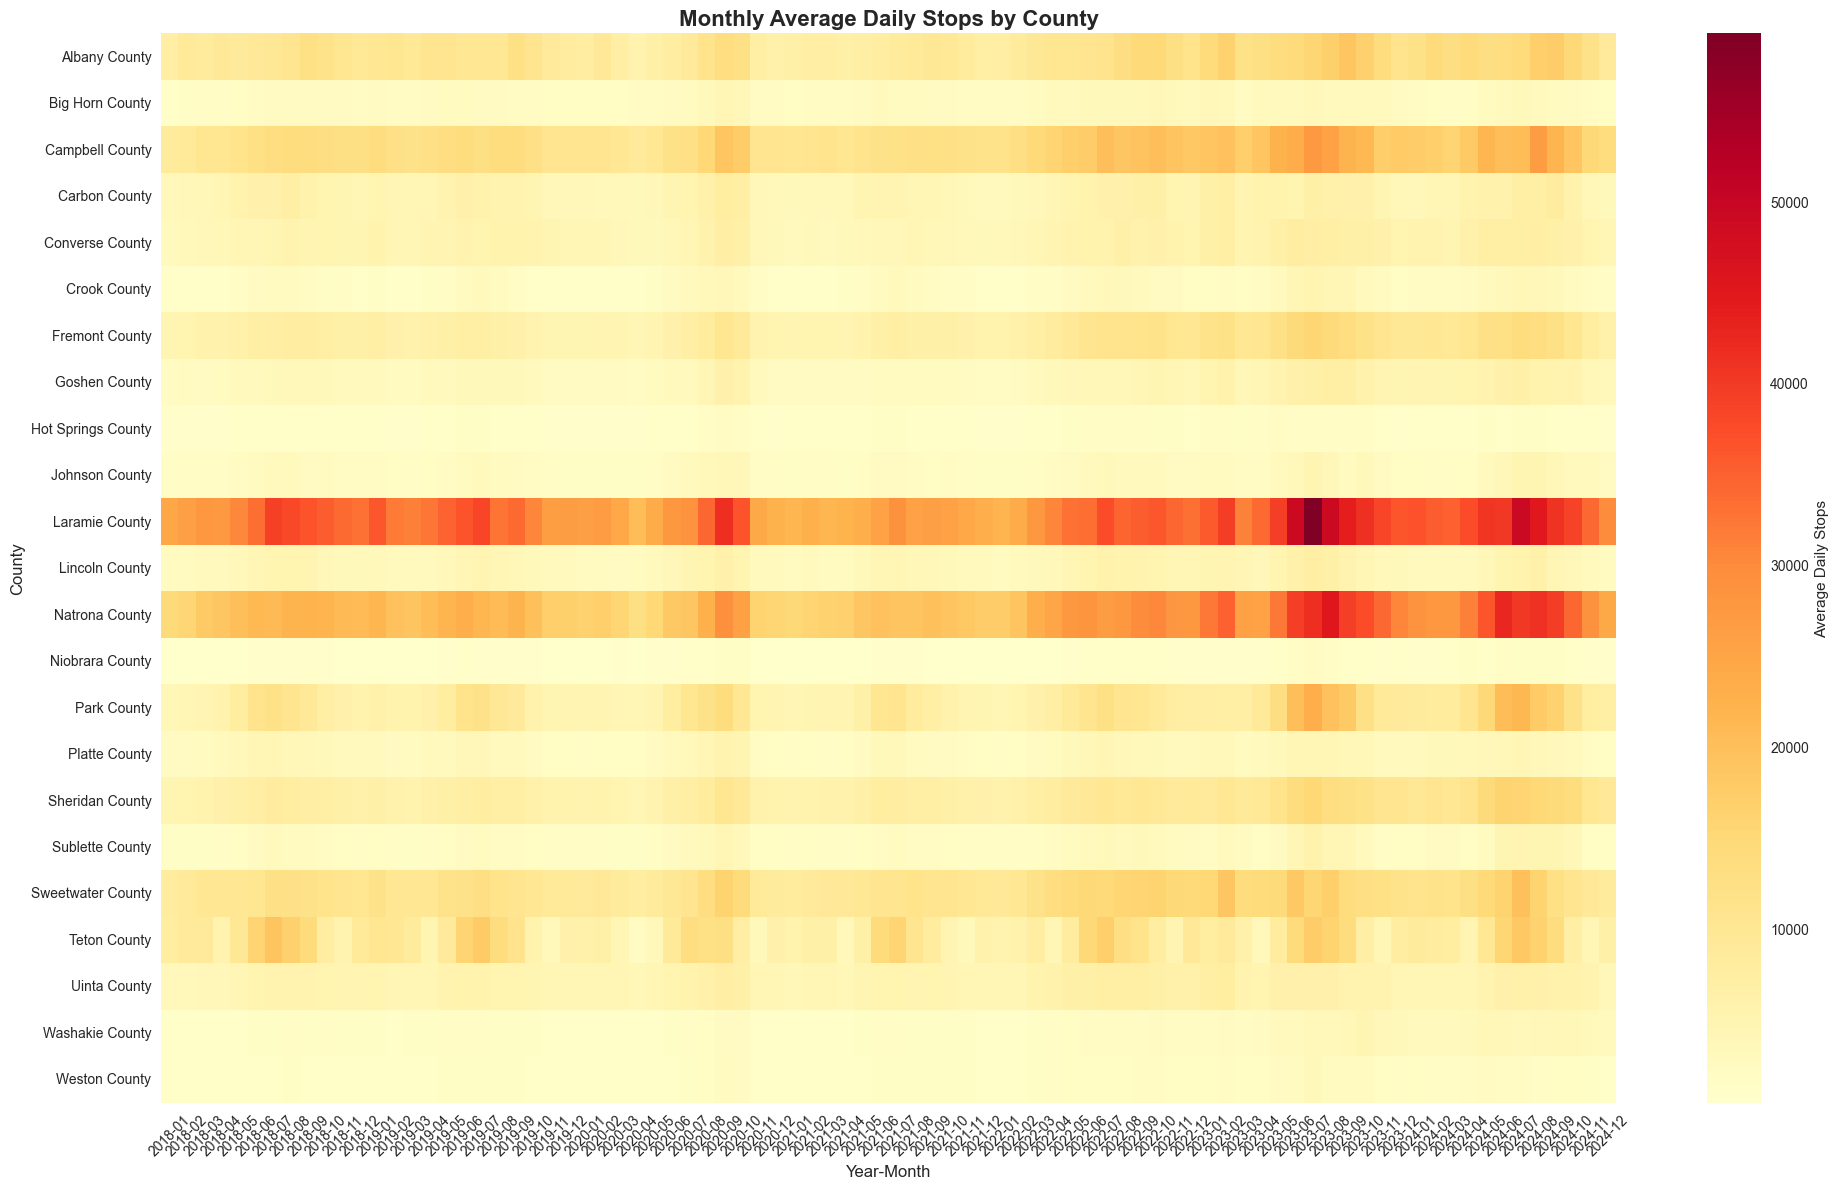

In [6]:
# Our goal is to identify seasonal patterns.
# We will create a heatmap with the following structure:
#   rows  = county
#   cols  = "year-month"
#   value = mean daily stops that month

def create_heatmap_analysis(dataframe, out_dir):
    out_dir = Path(out_dir)

    # Break the date into components
    df_copy = dataframe.copy()
    df_copy['Year'] = df_copy['DATE'].dt.year
    df_copy['Month'] = df_copy['DATE'].dt.month

    # Compute the monthly average daily stops for each county
    heatmap_data = (
        df_copy
        .groupby(['COUNTY_NAME', 'Year', 'Month'])['TOTAL_DAILY_STOPS']
        .mean()
        .reset_index()
    )

    # make a "YYYY-MM" style label for columns
    heatmap_data['Year_Month'] = (
        heatmap_data['Year'].astype(str)
        + '-'
        + heatmap_data['Month'].astype(str).str.zfill(2)
    )

    # pivot: rows = county, cols = Year_Month, values = avg stops
    pivot_data = heatmap_data.pivot(
        index='COUNTY_NAME',
        columns='Year_Month',
        values='TOTAL_DAILY_STOPS'
    )

    # convert Year_Month back to datetime for ordering
    pivot_data = pivot_data.reindex(
        sorted(pivot_data.columns, key=lambda x: pd.to_datetime(x)),
        axis=1
    )

    fig, ax = plt.subplots(figsize=(20, 12))

    sns.heatmap(
        pivot_data,
        cmap='YlOrRd',
        cbar_kws={'label': 'Average Daily Stops'},
        ax=ax
    )

    ax.set_title(
        'Monthly Average Daily Stops by County',
        fontsize=16,
        fontweight='bold'
    )
    ax.set_ylabel('County', fontsize=12)
    ax.set_xlabel('Year-Month', fontsize=12)

    # rotate column labels to avoid collisions
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.savefig(out_dir / "Monthly_Heatmap_Counties.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


# run it
create_heatmap_analysis(df, OUTPUT_DIR)


### ***6. Summary statistics and ranking charts***

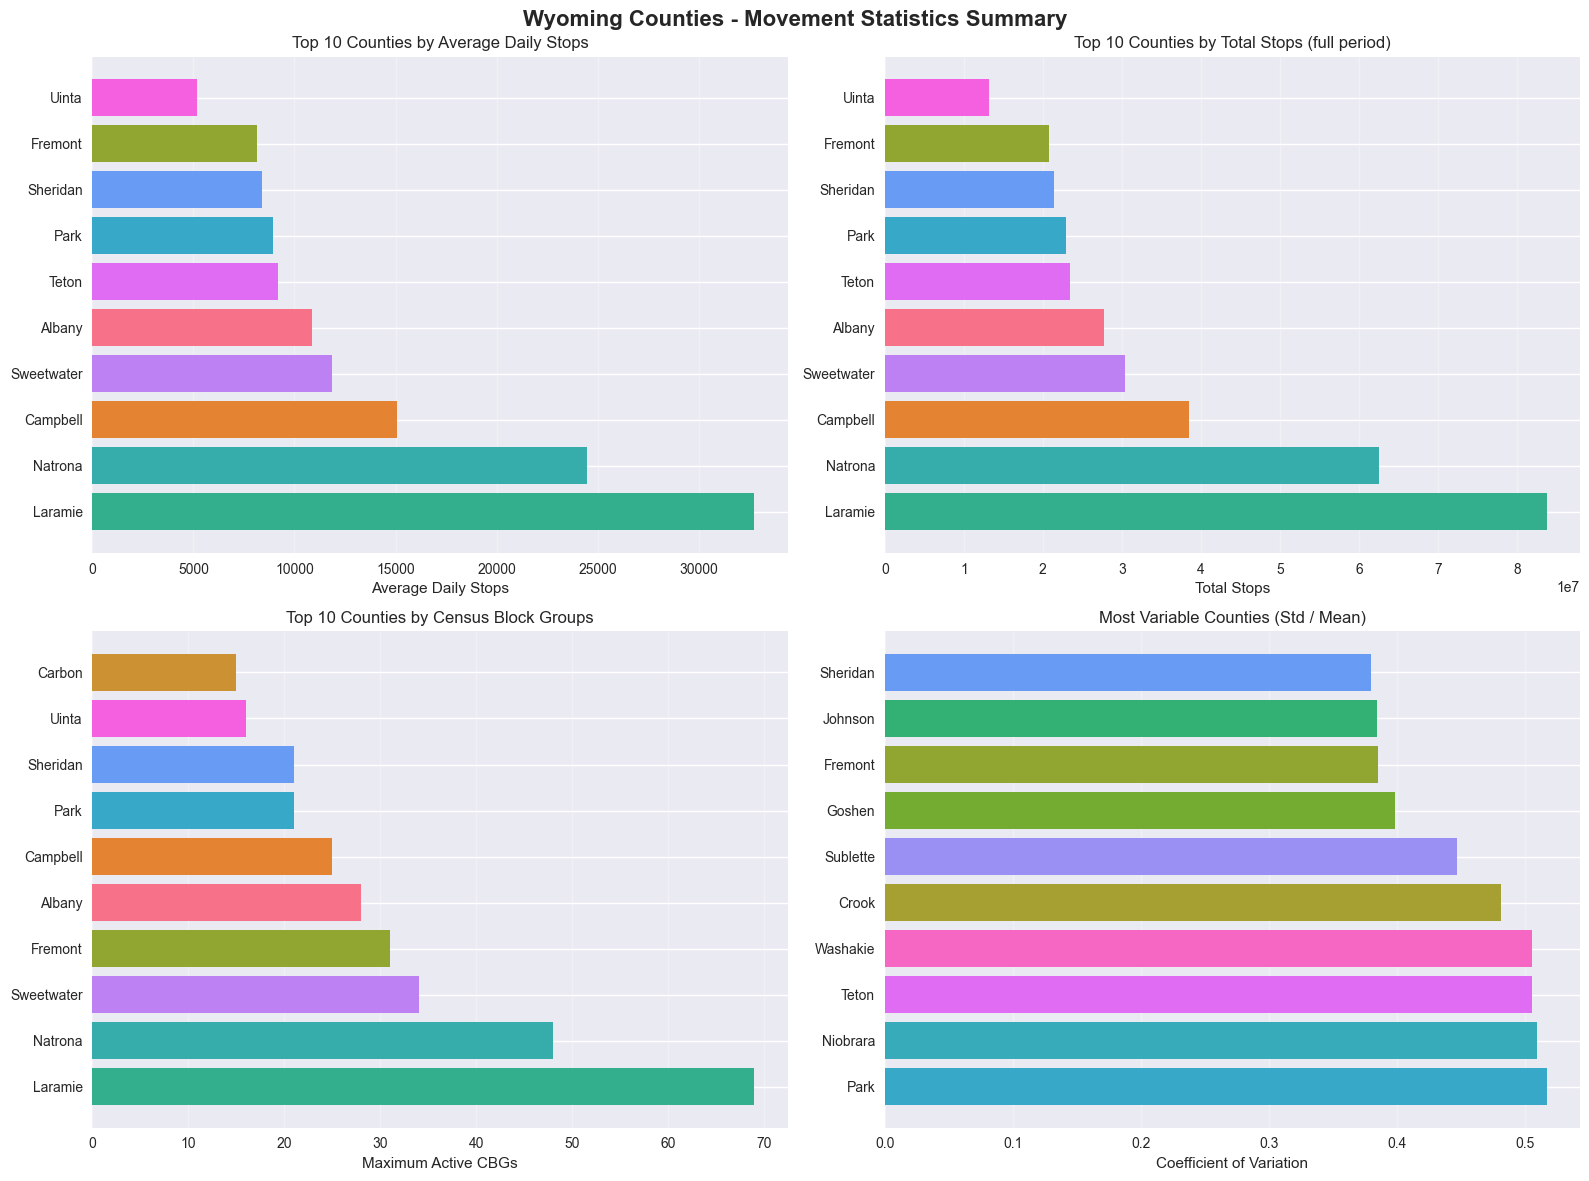

Saved County_Statistics_Summary.png and County_Statistics_Summary.csv


In [7]:
# Here we summarize each county:
#   - mean / std / min / max / total stops (over the whole period)
#   - max number of active CBGs
#   - data coverage (first date, last date, # days)
#
# Then we make a 2x2 dashboard:
#   1. which counties have the highest avg daily stops
#   2. which counties have the biggest total stops
#   3. which counties light up the most CBGs
#   4. which counties are most variable (std/mean)


def create_summary_statistics(dataframe, out_dir, color_map):
    out_dir = Path(out_dir)

    county_stats = (
        dataframe
        .groupby('COUNTY_NAME')
        .agg({
            'TOTAL_DAILY_STOPS': ['mean', 'std', 'min', 'max', 'sum'],
            'UNIQUE_CBGS_COUNT': 'max',
            'DATE': ['min', 'max', 'count']
        })
        .round(2)
    )

    county_stats.columns = [
        'Mean_Daily', 'Std_Daily', 'Min_Daily', 'Max_Daily', 'Total_Stops',
        'Max_CBGs', 'First_Date', 'Last_Date', 'Total_Days'
    ]

    county_stats = county_stats.sort_values('Mean_Daily', ascending=False)

    # Add coefficient of variation for later ranking
    county_stats['CV'] = county_stats['Std_Daily'] / county_stats['Mean_Daily']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(
        'Wyoming Counties - Movement Statistics Summary',
        fontsize=16,
        fontweight='bold'
    )

    # Top 10 by average daily stops
    top_10 = county_stats.head(10)
    axes[0,0].barh(
        range(len(top_10)),
        top_10['Mean_Daily'],
        color=[color_map[c] for c in top_10.index]
    )
    axes[0,0].set_yticks(range(len(top_10)))
    axes[0,0].set_yticklabels([c.replace(' County', '') for c in top_10.index])
    axes[0,0].set_xlabel('Average Daily Stops')
    axes[0,0].set_title('Top 10 Counties by Average Daily Stops')
    axes[0,0].grid(True, alpha=0.3, axis='x')

    # Top 10 by total stops
    top_10_total = county_stats.sort_values('Total_Stops', ascending=False).head(10)
    axes[0,1].barh(
        range(len(top_10_total)),
        top_10_total['Total_Stops'],
        color=[color_map[c] for c in top_10_total.index]
    )
    axes[0,1].set_yticks(range(len(top_10_total)))
    axes[0,1].set_yticklabels([c.replace(' County', '') for c in top_10_total.index])
    axes[0,1].set_xlabel('Total Stops')
    axes[0,1].set_title('Top 10 Counties by Total Stops (full period)')
    axes[0,1].grid(True, alpha=0.3, axis='x')

    # Top 10 by max active CBG count
    top_10_cbgs = county_stats.sort_values('Max_CBGs', ascending=False).head(10)
    axes[1,0].barh(
        range(len(top_10_cbgs)),
        top_10_cbgs['Max_CBGs'],
        color=[color_map[c] for c in top_10_cbgs.index]
    )
    axes[1,0].set_yticks(range(len(top_10_cbgs)))
    axes[1,0].set_yticklabels([c.replace(' County', '') for c in top_10_cbgs.index])
    axes[1,0].set_xlabel('Maximum Active CBGs')
    axes[1,0].set_title('Top 10 Counties by Census Block Groups')
    axes[1,0].grid(True, alpha=0.3, axis='x')

    # Top 10 by coefficient of variation (std/mean)
    top_10_cv = county_stats.sort_values('CV', ascending=False).head(10)
    axes[1,1].barh(
        range(len(top_10_cv)),
        top_10_cv['CV'],
        color=[color_map[c] for c in top_10_cv.index]
    )
    axes[1,1].set_yticks(range(len(top_10_cv)))
    axes[1,1].set_yticklabels([c.replace(' County', '') for c in top_10_cv.index])
    axes[1,1].set_xlabel('Coefficient of Variation')
    axes[1,1].set_title('Most Variable Counties (Std / Mean)')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig(out_dir / "County_Statistics_Summary.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    # Exportxport the numeric summary to CSV
    county_stats.to_csv(out_dir / "County_Statistics_Summary.csv")

    print("Saved County_Statistics_Summary.png and County_Statistics_Summary.csv")


# run it
create_summary_statistics(df, OUTPUT_DIR, county_colors)


### ***7. COVID-period Comparison***

In [ ]:
# # Finally, a quick look at how movement behaved across different COVID phases.
# #
# # We'll define several high-level "phases", average daily stops in each phase,
# # and then compare those for the top 8 most active counties overall.
# #
# # Result: bar chart where each color is a phase like "Initial Lockdown".


# def create_covid_impact_analysis(dataframe, out_dir, county_list, color_map):
#     out_dir = Path(out_dir)

#     # Define rough COVID timeline periods (you can tweak these date ranges)
#     covid_periods = {
#         'Pre-COVID':        ('2020-01-01', '2020-03-15'),
#         'Initial Lockdown': ('2020-03-15', '2020-05-15'),
#         'Recovery Phase':   ('2020-05-15', '2020-09-01'),
#         'Fall 2020':        ('2020-09-01', '2021-01-01'),
#         'Post-Vaccine':     ('2021-06-01', '2023-03-01')
#     }

#     period_stats = []

#     for county in county_list:
#         county_data = dataframe[dataframe['COUNTY_NAME'] == county].copy()

#         for period_name, (start, end) in covid_periods.items():
#             mask = (
#                 (county_data['DATE'] >= start) &
#                 (county_data['DATE'] <= end)
#             )
#             period_slice = county_data[mask]

#             if not period_slice.empty:
#                 period_stats.append({
#                     'County': county,
#                     'Period': period_name,
#                     'Avg_Daily_Stops': period_slice['TOTAL_DAILY_STOPS'].mean(),
#                     'Total_Days': len(period_slice)
#                 })

#     period_df = pd.DataFrame(period_stats)

#     # focus on the "top 8" most active counties overall
#     top_counties_covid = (
#         dataframe
#         .groupby('COUNTY_NAME')['TOTAL_DAILY_STOPS']
#         .mean()
#         .nlargest(8)
#         .index
#     )

#     # Pivot so we get: rows = county, cols = COVID period, values = avg daily stops
#     period_pivot = (
#         period_df[period_df['County'].isin(top_counties_covid)]
#         .pivot(index='County', columns='Period', values='Avg_Daily_Stops')
#     )

#     # Order the columns in rough chronological order
#     column_order = ['Pre-COVID', 'Initial Lockdown', 'Recovery Phase', 'Fall 2020', 'Post-Vaccine']
#     period_pivot = period_pivot.reindex(columns=column_order)

#     fig, ax = plt.subplots(figsize=(16, 10))

#     # simple bar chart by period (stacked as groups)
#     period_pivot.plot(
#         kind='bar',
#         ax=ax,
#         width=0.8,
#         color=['blue', 'red', 'orange', 'green', 'purple']
#     )

#     ax.set_title(
#         'COVID-19 Impact on Movement Patterns - Top 8 Wyoming Counties',
#         fontsize=14,
#         fontweight='bold'
#     )
#     ax.set_ylabel('Average Daily Stops', fontsize=12)
#     ax.set_xlabel('County', fontsize=12)
#     ax.legend(
#         title='COVID Period',
#         bbox_to_anchor=(1.05, 1),
#         loc='upper left'
#     )
#     ax.grid(True, alpha=0.3, axis='y')

#     ax.tick_params(axis='x', rotation=45)

#     plt.tight_layout()
#     plt.savefig(out_dir / "COVID_Impact_Analysis.png", dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close(fig)

#     print("✓ Saved COVID_Impact_Analysis.png")


# # run it
# create_covid_impact_analysis(df, OUTPUT_DIR, counties, county_colors)
